# TFTrade Model Experiments 


__Financial Prediction research__


Research about financial prediction on markets in MetaTrader 5.
Deriv Synthetic instruments are currently used as the primary instruments.

**NOTE:** Docker is required to run this notebook.



In [1]:
# !pip install pandas-ta yfinance docker python-dotenv

## Start MetaTrader 5 Docker Terminal

In [2]:
import logging
import time
from typing import Optional
from trade_flow.common.logging import Logger
from packages.mt5any import (
    DockerizedMT5TerminalConfig,
    DockerizedMT5Terminal,
)
from packages.mt5any import MetaTrader5


class MT5Exception(Exception):
    """Base exception class for MT5 errors."""

    pass


class MT5InitializationError(MT5Exception):
    """Raised when there is an error initializing MT5 Trader."""

    pass


class MT5:
    """
    A class to interface with MetaTrader 5 for trading operations using Dockerized MT5 Terminals.

    Attributes:
        mt5_account_number (str): The MetaTrader 5 account number.
        mt5_password (str): The password for the MT5 account.
        mt5_server (str): The MT5 server name.
        logger (Logger): Logger instance for logging events.
        mt5_terminal (DockerizedMT5Terminal): Dockerized MT5 Terminal instance.
        mt5 (MetaTrader5): MetaTrader 5 client interface.
        initial_balance (float): The initial account balance.
    """

    def __init__(
        self,
        account_number: str,
        password: str,
        server: str,
        logger: Optional[Logger] = None,
    ) -> None:
        """
        Initialize the MT5 class with account credentials and configurations.

        Args:
            account_number (str): MetaTrader 5 account number.
            password (str): MetaTrader 5 account password.
            server (str): MetaTrader 5 server.
            logger (Optional[Logger]): Logger instance for logging.
        """
        self.mt5_account_number = account_number
        self.mt5_password = password
        self.mt5_server = server

        # Set up logging
        self.logger = logger or Logger(name="tft_logger", log_level=logging.DEBUG, filename="TFT_model_experiments.log")

        # Set up MetaTrader 5 terminal and configuration
        self.mt5_config = DockerizedMT5TerminalConfig(
            account_number=self.mt5_account_number,
            password=self.mt5_password,
            server=self.mt5_server,
            read_only_api=True,
        )

        # Initialize Dockerized MT5 Terminal
        self.mt5_terminal = DockerizedMT5Terminal(config=self.mt5_config)
        self._initialize_terminal()

        # Initialize MetaTrader 5
        self.mt5 = MetaTrader5()
        self._initialize_mt5()
        self.logger.debug(f"Terminal Info: {self.mt5.terminal_info()._asdict()}")

        # Get account information
        self.account_info = self.mt5.account_info()._asdict()
        self.logger.debug(f"Account Info: {self.account_info}")

        self.initial_balance = self.account_info["balance"]

        # Log account info
        self.logger.info(f"Account Balance: {self.initial_balance}")
        self.logger.info(f"Equity: {self.account_info['equity']}")
        self.logger.info(f"Currency: {self.account_info['currency']}")
        self.logger.info(f"Margin: {self.account_info['margin']}")
        self.logger.info(f"Server: {self.account_info['server']}")
        self.logger.info(f"Name: {self.account_info['name']}")

    def _initialize_terminal(self) -> None:
        """Initialize and safely start the Dockerized MT5 Terminal."""
        try:
            self.mt5_terminal.safe_start()
            time.sleep(5)

            self.logger.info(f"MetaTrader 5 Terminal started for account {self.mt5_account_number}")
        except Exception as e:
            self.logger.error(f"Error initializing Dockerized MT5 Terminal: {e}")
            raise MT5InitializationError("Failed to start Dockerized MT5 Terminal")

    def _initialize_mt5(self) -> None:
        """Initialize the MetaTrader 5 client."""
        try:
            if not self.mt5.initialize():
                raise RuntimeError("MetaTrader 5 initialization failed")

            # if not self.mt5.login(self.mt5_account_number, self.mt5_password, self.mt5_server):
            #     raise RuntimeError("MetaTrader 5 login failed")
        except Exception as e:
            self.logger.error(f"Error initializing MetaTrader 5: {e}")
            raise MT5InitializationError("Failed to initialize MetaTrader 5")


/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/trade_flow/feed/__init__.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, parse_dates=True, index_col=index_name)


In [3]:
import os 
from dotenv import load_dotenv

load_dotenv()

mt5_venue = MT5(
    account_number=os.getenv("MT5_ACCOUNT_NUMBER"),
    password=os.getenv("MT5_PASSWORD"),
    server=os.getenv("MT5_SERVER"),
)


[TradeFlow] 225057 - 2024-10-16, 03:19:55 AM   [INFO] DockerizedMT5Terminal: Ensuring terminal is running
[TradeFlow] 225057 - 2024-10-16, 03:19:55 AM   [INFO] DockerizedMT5Terminal: status=<ContainerStatus.READY: 6>, using existing container
[TradeFlow] 225057 - 2024-10-16, 03:20:00 AM   [INFO] tft_logger: MetaTrader 5 Terminal started for account 30565290
[TradeFlow] 225057 - 2024-10-16, 03:20:01 AM   [DEBUG] tft_logger: Terminal Info: {'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 4490, 'maxbars': 100000, 'codepage': 0, 'ping_last': 133627, 'community_balance': 0.0, 'retransmission': 0.0, 'company': 'MetaQuotes Ltd.', 'name': 'MetaTrader 5', 'language': 'English', 'path': 'C:\\Program Files\\MetaTrader 5', 'data_path': 'C:\\Program Files\\MetaTrader 5', 'commondata_path': 'C:\\us

In [4]:
mt5_venue

## Import Libraries

In [5]:
# base import
import os
import sys
import json
import yaml
import time
import random 
import numpy as np
import pandas as pd
import pandas_ta as ta
import sklearn as sk
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt

from typing import List, Tuple
from datetime import datetime, timedelta

import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from IPython.display import clear_output
# import jtplot module in notebook
# from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='solarizedd')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [6]:
# plt.style.available
plt.style.use('seaborn-v0_8-whitegrid')

In [7]:
def set_seeds(seed=100):
    random.seed(seed)          # Set seed for Python's random module
    np.random.seed(seed)       # Set seed for NumPy's random module
    torch.manual_seed(seed)    # Set seed for PyTorch
    torch.cuda.manual_seed(seed)  # Set seed for CUDA if using GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cuDNN
    torch.backends.cudnn.benchmark = False      # Disable the benchmark for deterministic results

set_seeds()

## Library Version and Docs

In [8]:
print("Library version:")
print("\t-  pandas: {}".format(pd.__version__))
print("\t-  numpy: {}".format(np.__version__))
print("\t-  sklearn: {}".format(sk.__version__))
print("\t-  torch: {}".format(torch.__version__))
print("\t-  matplotlib: {}".format(matplot.__version__))
print("\t-  python: {}".format(sys.version[:sys.version.find('(') - 1]))

Library version:
	-  pandas: 2.2.3
	-  numpy: 1.26.4
	-  sklearn: 1.5.2
	-  torch: 2.4.1+cu121
	-  matplotlib: 3.9.2
	-  python: 3.11.10 | packaged by conda-forge |


In [9]:
df = pd.DataFrame()

df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [10]:
help(ta.sma)

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     

## Load data

### Initialize MetaTrader 5

In [11]:
mt5 = mt5_venue.mt5

# INITIALIZE THE DEVICE
mt5.initialize()


True

### Fetch All Available Symbols

In [12]:
# Create empty lists
symbols = []
sectors = []
descriptions = []

# Get the information for all symbol
symbols_information = mt5.symbols_get()

symbols_information

(SymbolInfo(custom=False, chart_mode=0, select=False, visible=False, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=0, digits=5, spread=0, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=20, trade_freeze_level=3, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=True, expiration_mode=15, filling_mode=1, order_mode=63, order_gtc_mode=0, option_mode=0, option_right=0, bid=0.0, bidhigh=0.0, bidlow=0.0, ask=0.0, askhigh=0.0, asklow=0.0, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=1e-05, trade_tick_value=0.7255156602555267, trade_tick_value_profit=0.7255156602555267, trade_tick_value_loss=0.725631480796163, trade_tick_size=1e-05, trade_contract_size=100000.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume_min=0.01, volume_max=10

In [13]:
len(symbols_information)

297

### Extract Symbols Information

In [14]:
symbols = [element[-3] for element in symbols_information]
sectors = [element[-1].split("\\")[0] for element in symbols_information]
descriptions = [element[-7] for element in symbols_information]

# Create a dataframe directly from the extracted lists
informations = pd.DataFrame({
    "Symbol": symbols,
    "Sector": sectors,
    "Description": descriptions
})

informations

,Symbol,Sector,Description
0,AUDCAD,Forex Minor,Australian Dollar vs Canadian Dollar
1,AUDCHF,Forex Minor,Australian Dollar vs Swiss Franc
2,AUDNZD,Forex Minor,Australian Dollar vs New Zealand Dollar
3,AUDJPY,Forex Major,Australian Dollar vs Japanese Yen
4,AUDUSD,Forex Major,Australian Dollar vs US Dollar
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Remove Forex Pairs**

In [15]:
filtered_Informations = informations[~informations['Sector'].str.contains("Forex")]

filtered_Informations

,Symbol,Sector,Description
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Take some Volatility pairs**

In [16]:
# Filter out rows where 'Symbol' does not contains 'Volatility'
# filter_volatility_pairs = informations[informations['Symbol'].str.contains("Volatility")]

# filter_volatility_pairs

### Select Symbols 

In [17]:
# selected_df = pd.concat([lowest_spread_asset, filter_volatility_pairs])
selected_df = filtered_Informations

selected_df

,Symbol,Sector,Description
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Select the symbols on MT5**

In [18]:
# Loop through the selected symbols and select them in MetaTrader5
for symbol in selected_df['Symbol']:
    # Try to select the symbol, raise an error if it fails
    if not mt5.symbol_select(symbol, True):
        raise ValueError(f"Failed to enable symbol: {symbol}")
    else:
        print(f"Symbol enabled: {symbol}")

Symbol enabled: Volatility 10 Index
Symbol enabled: Volatility 25 Index
Symbol enabled: Volatility 50 Index
Symbol enabled: Volatility 75 Index
Symbol enabled: Volatility 100 Index
Symbol enabled: Volatility 10 (1s) Index
Symbol enabled: XAGUSD
Symbol enabled: XAUUSD
Symbol enabled: XPDUSD
Symbol enabled: XPTUSD
Symbol enabled: ADAUSD
Symbol enabled: ALGUSD
Symbol enabled: AVAUSD
Symbol enabled: BATUSD
Symbol enabled: BCHUSD
Symbol enabled: BNBUSD
Symbol enabled: BTCETH
Symbol enabled: BTCLTC
Symbol enabled: BTCUSD
Symbol enabled: DOGUSD
Symbol enabled: DOTUSD
Symbol enabled: DSHUSD
Symbol enabled: EOSUSD
Symbol enabled: ETCUSD
Symbol enabled: ETHUSD
Symbol enabled: FILUSD
Symbol enabled: IOTUSD
Symbol enabled: LNKUSD
Symbol enabled: LTCUSD
Symbol enabled: Boom 1000 Index
Symbol enabled: Boom 500 Index
Symbol enabled: Crash 1000 Index
Symbol enabled: Crash 500 Index
Symbol enabled: Step Index
Symbol enabled: Range Break 100 Index
Symbol enabled: Range Break 200 Index
Symbol enabled: Vo

### Define Get data function

In [19]:
def get_data(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """ Function which returns the data of the symbol"""

    # Initialize MetaTrader device
    mt5.initialize()

    # Get symbol information and ensure visibility
    if not mt5.symbol_select(symbol, True):
        raise ValueError(f"Failed to enable symbol: {symbol}")
    
    # Put the data in a dataframe
    utc_from = datetime.now()+timedelta(hours=2)
    rates = mt5.copy_rates_from(symbol, timeframe, utc_from,n) 
    rates_frame = pd.DataFrame(rates)
    
    # Convert time in seconds into the datetime format 
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame['time'] =  pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    rates_frame = rates_frame.set_index('time')
    
    return rates_frame

## Find the Best Spread Threshold

In [20]:
# Create a list to store the spread values
spread = []

# Compute the spread using a list comprehension for efficiency
spread = [
    (tick.ask - tick.bid) / tick.bid if (tick := mt5.symbol_info_tick(symbol)) and tick.ask and tick.bid else None
    for symbol in selected_df["Symbol"]
]

spread

[2.7758199530795377e-05,
 7.018368071864962e-05,
 0.0001432198089887957,
 0.0002533004939524069,
 0.000305741386464445,
 2.72778951939622e-05,
 0.0007923679122690924,
 0.0001462909614691636,
 0.004951865103682756,
 0.0020741456734932836,
 0.0013406323315830087,
 0.003990422984836396,
 0.0014265335235377728,
 0.001994238865499663,
 0.002877094052725793,
 0.0008925231057791528,
 0.0020931092629534786,
 0.0017699813154906572,
 0.0007664384118633737,
 0.001625042764283353,
 0.0018206645425580352,
 0.0018569718978252033,
 0.003253529772866749,
 0.0014314196615714274,
 0.0009324437924161842,
 0.010554089709762543,
 0.004758128469468812,
 0.0011411516853932497,
 0.001155824730324952,
 4.329862116168746e-05,
 6.442372637676274e-05,
 4.254106846078968e-05,
 7.439008449099876e-05,
 2.4567006510234382e-05,
 2.978753364653086e-05,
 2.166219965863959e-05,
 6.914078187270148e-05,
 0.0001331594791792471,
 0.0002104391466863642,
 0.00031696223394989695,
 0.009174311926605457,
 0.002740195238910714,
 0

In [21]:
min_spread = min([x for x in spread if x is not None])

min_spread

1.81184037686939e-05

In [22]:
max_spread = max([x for x in spread if x is not None])

max_spread

0.3333333333333334

In [23]:
mean_spread = np.mean([min_spread, max_spread])

mean_spread

0.16667572586855106

In [24]:
mean_spread/100

0.0016667572586855106

In [25]:
# if mean_spread < 0.01:
#     spread_threshold = np.round(mean_spread * 100, 4) # 0.0035
# else:
#     spread_threshold = mean_spread

spread_threshold = np.round(mean_spread / 100, 4) # 0.0035
spread_threshold

0.0017

#### Take the assets with low spreads

In [26]:
selected_df["Spread"] = spread

# Take the assets with the spread < spread_threshold(%)
lowest_spread_asset = selected_df.dropna().loc[selected_df["Spread"]<spread_threshold]
lowest_spread_asset

,Symbol,Sector,Description,Spread
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...,0.000028
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...,0.000070
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...,0.000143
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...,0.000253
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...,0.000306
...,...,...,...,...
288,Skew Step Index 5 Down,Skewed Step,Offers 90% chance of gradual declines; 10% cha...,0.000498
289,Skew Step Index 4 Up,Skewed Step,Offers 80% chance of gradual gains; 20% chance...,0.000409
290,Skew Step Index 4 Down,Skewed Step,Offers 80% chance of gradual declines; 20% cha...,0.000393
291,Vol over Boom 550,Hybrid Indices,Volatility of 20% with on average 1 splike eve...,0.000208


## Select Final Assets 

In [27]:
# final_assets = lowest_spread_asset
final_assets = lowest_spread_asset.head(10)
# Fill Assets with no spread with max spread value
# final_assets['Spread'] = final_assets['Spread'].fillna(max_spread) 

final_assets

,Symbol,Sector,Description,Spread
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...,0.000028
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...,0.000070
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...,0.000143
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...,0.000253
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...,0.000306
37,Volatility 10 (1s) Index,Volatility Indices,Constant Volatility of 10% with a tick every 1...,0.000027
38,XAGUSD,Metals,Silver vs US Dollar,0.000792
39,XAUUSD,Metals,Gold vs US Dollar,0.000146
42,ADAUSD,Crypto,Cardano vs US Dollar,0.001341
44,AVAUSD,Crypto,Avalanche vs US Dollar,0.001427


## Features engineering 


### Define Normalization Scheme

This class apply logarithm and a normalization(MinMax | StandarScale | Normalizer_l1 | Normalizer_l2).

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

class Normalizer:
    """
    A class for normalizing market data while preserving the original data.

    This class applies logarithm and a normalization (MinMax, StandardScale, Normalizer_l1, Normalizer_l2).
    """

    def __init__(self, data):
        """
        Initializes the Normalizer class with market data.

        Args:
            data (list[dict]): A list of dictionaries, where each dictionary represents a market
                               with keys like "name" and "data" (containing market data).
        """
        self.__market_names = [e["name"] for e in data]
        self.__original_data = [pd.DataFrame(e["data"]) for e in data]  # Convert to DataFrame
        self.__normalized_data = None  # Stores normalized data after fit is called

    def __normalize(self, target, numerical_data, scaler_func):
        """
        Normalizes data using the provided scaler function for specific target markets.

        Args:
            target (str): The target market(s) to normalize ("all" or a list of market names).
            numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
            scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).

        Returns:
            list[pd.DataFrame]: List of normalized market DataFrames.
        """
        normalized_markets = []
        target_markets = self.__market_names if target == "all" else target

        for market_name, market in zip(self.__market_names, numerical_data):
            if market_name in target_markets:
                columns = market.columns
                market_scaled = scaler_func(market)
                normalized_markets.append(pd.DataFrame(market_scaled, columns=columns))

        return normalized_markets

    def fit(self, norm_type, features_list, target="all"):
        """
        Performs data normalization based on the specified type, features, and target market(s).

        Args:
            norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
            features_list (list): A list of feature names to consider for normalization.
            target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

        Raises:
            ValueError: If an invalid normalization type is provided.
        """
        # Extract numerical data for the specified features
        numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

        if norm_type == "MinMax":
            print(f"Performing MinMax Normalization on {target}.")
            scaler_func = MinMaxScaler().fit_transform
        elif norm_type == "StandardScale":
            print(f"Performing StandardScale Normalization on {target}.")
            scaler_func = StandardScaler().fit_transform
        elif norm_type.startswith("Normalizer"):
            norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
            if norm_value not in ("l1", "l2"):
                raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
            print(f"Performing Normalizer (norm={norm_value}) on {target}.")
            scaler_func = SklearnNormalizer(norm=norm_value).fit_transform
        else:
            raise ValueError(f"Invalid normalization type: {norm_type}")

        self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)

    def get_normalized_data(self, idx: int = None):
        """
        Returns the normalized data if normalization has been performed, otherwise raises an error.
        
        Args:
            idx (int, optional): The location/index of the normalized data. If None, returns all normalized data.

        Raises:
            RuntimeError: If data has not been normalized yet.
            IndexError: If the index is out of range.
        """
        if self.__normalized_data is None:
            raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
        if idx is not None:
            if idx < 0 or idx >= len(self.__normalized_data):
                raise IndexError("Index out of range.")
            return self.__normalized_data[idx]
        
        return self.__normalized_data  # Return all normalized data if idx is None

    def get_original_data(self):
        """
        Returns the original, un-normalized data.
        """
        return [data.copy() for data in self.__original_data]  # Return a deep copy


### Define PEAKS Detection 

This function detect peaks with a delta.

Choosing a default delta value for the peakdet function depends on the characteristics of your data and the desired level of peak/valley sensitivity. Here are some considerations:

- Data Scale: If your data values are on a large scale (e.g., stock prices in the thousands), a larger delta might be appropriate to avoid detecting insignificant fluctuations.
- Noise Level: If your data has a high level of noise, a larger delta might be necessary to filter out minor variations and focus on more prominent peaks and valleys.
- Desired Sensitivity: If you want to capture a broad range of peaks and valleys, a smaller delta would be suitable. However, this might also lead to detecting insignificant pumps or dips.
  
Here are some possible default values based on common scenarios:

- General Case: A reasonable starting point for many applications could be a delta value between 0.01 and 0.1. This range is a relative percentage of the data scale and can capture significant peaks and valleys without being overly sensitive to noise.
- Highly Scaled Data (e.g., Stock Prices): You might consider a delta between 1.0 and 10.0 for data with large values.
- Noisy Data: A delta between 0.05 and 0.2 could be a starting point for data with significant noise.

In [29]:

def peaks_detection(data: list[float], delta: float = 0.01, x: list[float] = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Finds peaks and valleys in a data series.

    Args:
        data (list[float]): The data series.
        delta (float): The threshold for a peak or valley.
        x (list[float], optional): The x-axis values (optional). Defaults to None.

    Returns:
        tuple[np.ndarray, np.ndarray]: Two numpy arrays, the first containing the indices and values of the peaks,
               the second containing the indices and values of the valleys.
    """

    data_array = np.asarray(data)  # Ensure NumPy array for efficiency

    if x is None:
        x = np.arange(len(data_array))  # Create x-axis if not provided

    peaks: list[tuple[float, float]] = []
    valleys: list[tuple[float, float]] = []
    current_peak = np.inf
    current_valley = -np.inf
    peak_pos = np.nan
    valley_pos = np.nan
    looking_for_peak = True  # Flag to track search direction

    for i, this_value in enumerate(data_array):
        # Update current peak and valley values
        current_peak = max(current_peak, this_value)
        current_valley = min(current_valley, this_value)

        if looking_for_peak:
            if this_value < current_peak - delta:
                if not np.isnan(peak_pos):
                    peaks.append((x[int(peak_pos)], current_peak))
                # peaks.append((x[int(peak_pos)], current_peak))
                current_valley = this_value
                valley_pos = i
                looking_for_peak = False
        else:
            if this_value > current_valley + delta:
                if not np.isnan(valley_pos):
                    valleys.append((x[int(valley_pos)], current_valley))
                # valleys.append((x[int(valley_pos)], current_valley))
                current_peak = this_value
                peak_pos = i
                looking_for_peak = True

    return np.array(peaks), np.array(valleys)


### Define Frame labelization 

Currently: buy, sell, wait/neutral

update to: strong buy, buy, strong sell, sell, wait/neutral (can also use the prediction probability to determine this 
e.g when a buy is >=75%, it can indicate a strong buy)

can also rename wait to neutral 


In [30]:
class MarketLabeler:
    """
    A class for labeling market data with buy, sell, or neutral signals based on peak information.
    """

    def __init__(self, peaks_max, peaks_min):
        """
        Initializes the MarketLabeler with peak data.

        Args:
            peaks_max (list): A list of tuples representing peak maxima (index, value).
            peaks_min (list): A list of tuples representing peak minima (index, value).
        """
        self.peaks_max = peaks_max
        self.peaks_min = peaks_min

    def label_data(self, data):
        """
        Labels each data point with a buy, sell, or neutral signal based on peaks.

        Args:
            data (list): A list representing the market data (e.g., prices).

        Returns:
            list: A list of labels (0 for neutral, 1 for sell, 2 for buy) corresponding to each data point.
        """
        labels = []
        for i, _ in enumerate(data):  # Iterate through data indices
            if any(idx == i for idx, _ in self.peaks_min):
                labels.append(0)  # Buy signal if peak min
            elif any(idx == i for idx, _ in self.peaks_max):
                labels.append(1)  # Sell signal if peak max
            else:
                labels.append(2)  # Neutral otherwise
        return labels

    def label_dataframe(self, frame_base: pd.DataFrame, data_column: str = "close"):
        """
        Labels a DataFrame with buy, sell, and neutral columns based on peak information.

        Args:
            frame_base (pd.DataFrame): The DataFrame containing the market data.
            data_column (str, optional): The name of the column containing the data to be labeled. Defaults to "close".

        Returns:
            pd.DataFrame: The updated DataFrame with added "buy", "sell", and "neutral" columns.
        """
        if data_column not in frame_base.columns:
            raise ValueError(f"Data column '{data_column}' not found in the DataFrame.")

        labels = self.label_data(frame_base[data_column])
        
        frame_base["buy"] = [1 if label == 0 else 0 for label in labels]
        frame_base["sell"] = [1 if label == 1 else 0 for label in labels]
        frame_base["neutral"] = [1 if label == 2 else 0 for label in labels]
    
        return frame_base



### Define Data Generator

In [31]:

class DataGenerator:
    """
    A class that generates data for training and testing.

    Args:
        dataset (pd.DataFrame): The input dataset.
        timestep (int): The number of timesteps to consider for each sample.
        xcols (List[str]): The column names to be used as input features.
        ycols (List[str]): The column names to be used as output labels.

    Methods:
        generate_data: Generates the input-output pairs for training and testing.
        balance_labelization: Balances the label distribution by removing excess neutral labels.
        train_test_split: Splits the data into training and testing sets.

    """

    def __init__(self, dataset: pd.DataFrame, timestep: int, xcols: List[str], ycols: List[str]):
        self.dataset = dataset
        self.timestep = timestep
        self.xcols = xcols
        self.ycols = ycols

    def generate_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generates the input-output pairs for training and testing.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the input and output arrays.

        """
        dx = [np.array(self.dataset.iloc[i : i + self.timestep][self.xcols]) for i in range(len(self.dataset) - self.timestep)]
        dy = [self.dataset.iloc[i + self.timestep - 1][self.ycols] for i in range(len(self.dataset) - self.timestep)]
        return np.array(dx), np.array(dy)

    def balance_labelization(self, frame: np.ndarray, label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Balances the label distribution by removing excess neutral labels.

        Args:
            frame (np.ndarray): The input array.
            label (np.ndarray): The label array.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the balanced input and label arrays.

        """
        neutral_indices = np.where(label[:, 2] == 1)[0]
        sell_indices = np.where(label[:, 1] == 1)[0]
        buy_indices = np.where(label[:, 0] == 1)[0]

        neutral_count = len(neutral_indices)
        sell_count = len(sell_indices)
        buy_count = len(buy_indices)

        need_delete = neutral_count - min(sell_count, buy_count)
        rand_delete = np.random.choice(neutral_indices, need_delete, replace=False)

        final_frame = np.delete(frame, rand_delete, axis=0)
        final_label = np.delete(label, rand_delete, axis=0)

        return final_frame, final_label

    def train_test_split(self, test_per: float, balance: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Splits the data into training and testing sets.

        Args:
            test_per (float): The percentage of data to be used for testing.
            balance (bool, optional): Whether to balance the label distribution. Defaults to False.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing the training and testing input and label arrays.

        """
        x_tmp, y_tmp = self.generate_data()

        if balance:
            x_tmp, y_tmp = self.balance_labelization(x_tmp, y_tmp)

        x_train, x_test, y_train, y_test = train_test_split(x_tmp, y_tmp, test_size=test_per, random_state = 100, shuffle = settings['model_shuffle'])

        return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)


###  Add available technical analysis (TA) features

In [32]:

def add_ta_features(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Adds various technical analysis (TA) features to the provided DataFrame.
    
    This function calculates several technical indicators, including momentum, 
    volatility, statistics, trend, volume, overlap, and performance indicators. 
    The input DataFrame must include a "date" column for setting the index to 
    a DatetimeIndex.

    References:
    - https://github.com/twopirllc/pandas-ta/blob/main/examples/AIExample.ipynb
    """
    
    # Create a copy of the DataFrame to avoid modifying the original
    features_df = df.copy() 

    # VWAP requires the DataFrame index to be a DatetimeIndex.
    # Replace "datetime" with the appropriate column from your DataFrame
    
    features_df.set_index(pd.DatetimeIndex(features_df.index), inplace=True)
    try:
        features_df.drop(columns=[features_df.index.name], inplace=True)
    except KeyError:
        print(f"Column '{features_df.index.name}' does not exist in the DataFrame.")
    except Exception as e:
        print(f"An error occurred while dropping the column: {e}")


    # Calculate Returns and append to the features_df DataFrame
    # features_df.ta.log_return(cumulative=True, append=True)
    # features_df.ta.percent_return(cumulative=True, append=True)

    """ 
        Add TA Indicators
    """
    
    # Adding momentum indicators
    features_df.ta.mom(append=True)
    features_df.ta.rsi(append=True)
    features_df.ta.tsi(append=True)
    features_df.ta.er(append=True)
    features_df.ta.fisher(append=True)

    # Adding volatility indicators
    features_df.ta.true_range(append=True)
    features_df.ta.rvi(append=True)
    features_df.ta.bbands(append=True)
    features_df.ta.pdist(append=True)

    # Adding statistics indicators
    features_df.ta.skew(append=True)
    features_df.ta.kurtosis(append=True)
    features_df.ta.mad(append=True)
    features_df.ta.zscore(append=True)
    features_df.ta.entropy(append=True)

    # Adding trend indicators
    features_df.ta.adx(append=True)
    features_df.ta.dpo(lookahead=False, append=True)
    features_df.ta.psar(append=True)
    features_df.ta.long_run(append=True)
    features_df.ta.short_run(append=True)
    features_df.ta.qstick(append=True)

    # Adding volume indicators
    # features_df.ta.obv(append=True)

    # Adding overlap indicators
    features_df.ta.linreg(append=True)
    features_df.ta.supertrend(append=True)
    features_df.ta.hilo(append=True)
    features_df.ta.hlc3(append=True)
    features_df.ta.ohlc4(append=True)

    # Adding Simple Moving Averages (SMA)
    sma_windows = [2, 10, 15, 60]
    for ma_window in sma_windows:
        features_df.ta.sma(length=ma_window, sma=False, append=True)

    # Adding Exponential Moving Averages (EMA)
    ema_windows = [8, 21, 50]
    for ma_window in ema_windows:
        features_df.ta.ema(length=ma_window, sma=False, append=True)

    # Adding performance indicators
    # features_df.ta.percent_return(append=True)

    print("TA Columns Added")

    """ 
    #### Modify RSI (Relative Strength Index) Indicator

        - The RSI provides technical traders with signals about bullish and bearish price momentum, 
        and it is often plotted beneath the graph of an asset’s price.

        - An asset is usually considered overbought when the RSI is above 70 and oversold when it is below 30.

        - The RSI line crossing below the overbought line or above the oversold line is often seen by traders 
        as a signal to buy or sell.

        - The RSI works best in trading ranges rather than trending markets.
    """
    features_df["RSI_14"] = features_df["RSI_14"].round()  # Rounding RSI values to the nearest integer

    # Add Candle Stick Patterns   
    features_df.ta.cdl_pattern(name="all", append=True)

    return features_df


### Define features engineering function

In [33]:
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def features_engineering(df: pd.DataFrame, add_ta: bool = False, compress_features: bool = True) -> dict:
    """ 
    This function creates the necessary datasets for algorithms 
    by performing feature engineering, scaling, and PCA.

    Args:
        df (DataFrame): The input dataframe containing price data (including 'close', 'high', 'low').
        add_ta (bool): Whether to add technical analysis features. Defaults to False.
        compress_features (bool): Whether to apply PCA for dimensionality reduction. Defaults to True.

    Returns:
        dict: A dictionary containing the train, test, validation sets, 
              along with their scaled and PCA-transformed versions.
    """

    original_df = df.copy()

    # Define the feature columns
    feature_columns = [
        "returns t-1", 
        "mean returns 15", 
        "mean returns 60",
        "volatility returns 15", 
        "volatility returns 60"
    ]
    
    # Create new columns for returns and other features

    # Ensure returns column is in the dataframe
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sLow"] = (df["low"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sHigh"] = (df["high"] - df["close"].shift(1)) / df["close"].shift(1)

    # Feature engineering
    df["returns t-1"] = df["returns"].shift(1)
    df["mean returns 15"] = df["returns"].rolling(15).mean().shift(1)
    df["mean returns 60"] = df["returns"].rolling(60).mean().shift(1)
    df["volatility returns 15"] = df["returns"].rolling(15).std().shift(1)
    df["volatility returns 60"] = df["returns"].rolling(60).std().shift(1)

    # Add technical analysis features if specified
    if add_ta:
        df = add_ta_features(df)
        feature_columns = df.columns.to_list()

    # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
    imputer = IterativeImputer(random_state=0)
    df[feature_columns + ["returns"]] = imputer.fit_transform(df[feature_columns + ["returns"]])
    print(df)

    # Splitting data into train, test, and validation sets
    split_train_test = int(0.70 * len(df))
    split_test_valid = int(0.90 * len(df))

    # Train set creation
    X_train = df[feature_columns].iloc[:split_train_test]
    y_train_reg = df["returns"].iloc[:split_train_test]
    y_train_cla = np.round(df["returns"].iloc[:split_train_test] + 0.5)

    # Test set creation
    X_test = df[feature_columns].iloc[split_train_test:split_test_valid]
    y_test_reg = df["returns"].iloc[split_train_test:split_test_valid]

    # Validation set creation
    X_val = df[feature_columns].iloc[split_test_valid:]
    y_val_reg = df["returns"].iloc[split_test_valid:]

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Use the Normalizer for scaling
    # normalizer = Normalizer(data=[{"name": "X_train", "data": X_train}])
    # normalizer.fit("StandardScale", feature_columns)
    # # norm.fit(settings["normalization_fit_type"], settings["features_name"], settings["normalization_fit_target"])]

    # # Get normalized data
    # X_train_scaled = normalizer.get_normalized_data(0)  # Get the scaled data
    # X_test_scaled = normalizer.get_normalized_data(1)  # Get scaled test data
    # X_val_scaled = normalizer.get_normalized_data(2)  # Get scaled validation data

    # Prepare the features dictionary
    features_dict = {
        "df": original_df,
        "processed_df": df,
        "feature_columns": feature_columns, 
        "X_train": X_train, 
        "X_test": X_test, 
        "y_train_reg": y_train_reg, 
        "y_train_cla": y_train_cla,
        "X_train_scaled": X_train_scaled,
        "split_train_test": split_train_test,
        "split_test_valid": split_test_valid,
        "X_test_scaled": X_test_scaled,
        "y_test_reg": y_test_reg,
        "X_val": X_val,
        "X_val_scaled": X_val_scaled,
        "y_val_reg": y_val_reg,
    }

    # Apply PCA if specified
    if compress_features:
        pca = PCA(n_components=3)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        features_dict["X_train_pca"] = X_train_pca
        features_dict["X_test_pca"] = X_test_pca
        features_dict["X_val_pca"] = X_val_pca

    # Return all relevant datasets as a dictionary for clarity and organization
    return features_dict


## Find the best assets

In [34]:

def predictor(data: dict, model, reg: bool = True, spread: float = 0.035, compressed_features: bool = True) -> float:
    """
    Fits the model to the training data, makes predictions on the entire dataset, 
    and computes the strategy's Sharpe ratio based on the predictions.
    
    Args:
        data (dict): The output of the features_engineering function, containing the PCA-transformed datasets.
        model (object): The machine learning model to be used for prediction (e.g., classifier or regressor).
        reg (bool): If True, performs regression; otherwise, classification.
        spread (float): The transaction cost or spread to be considered in strategy returns.
        compressed_features (bool): If True, use PCA-transformed features; otherwise, use original features.

    Returns:
        float: The Sharpe ratio of the strategy based on predictions.
    """

    # Extract the data from the dictionary
    X_train = data["X_train_pca"] if compressed_features else data["X_train_scaled"]
    X_test = data["X_test_pca"] if compressed_features else data["X_test_scaled"]
    X_val = data["X_val_pca"] if compressed_features else data["X_val_scaled"]
    y_train_reg = data["y_train_reg"]
    y_train_cla = data["y_train_cla"]
    df = data["processed_df"]
    split_train_test = data["split_train_test"]
    split_test_valid = data["split_test_valid"]

    # Fit the model on the training data
    print("Model type:", type(model).__name__)

    # Fit the model on the training data
    model.fit(X_train, y_train_cla)

    # Clean the dataframe
    # df = df.dropna()
    # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
    imputer = IterativeImputer(random_state=0)
    clean_data = imputer.fit_transform(df)
    df = pd.DataFrame(clean_data, columns=data["processed_df"].columns)
    
    # Create predictions for the concatenated dataset (train, test, validation)
    predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

    # Convert classification predictions to -1 (sell) and 1 (buy)
    if not reg:
        predictions = np.where(predictions == 0, -1, 1)
        # predictions = np.argmax(predictions, axis=1)  # Assuming model returns probabilities

    # Add predictions to the dataframe
    df["prediction"] = predictions

    # Compute the strategy returns (prediction * actual returns)
    df["strategy"] = df["prediction"] * df["returns"]

    # Select strategy returns only for the test set period
    returns = df["strategy"].iloc[split_train_test:split_test_valid]

    # Compute the Sharpe ratio of the strategy
    sharpe_ratio = np.sqrt(252) * (returns.mean() - (spread / 100)) / returns.std()

    return sharpe_ratio


In [36]:
# Import the necessary libraries
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import concurrent.futures

# Initialize models (only once)
tree = DecisionTreeClassifier(max_depth=20)
svr = SVC(C=1.5)
lin = LogisticRegression()

# Symbols list from final_assets
symbols = final_assets["Symbol"]

# To store results
results_list = []

# Define the function for processing each symbol
def process_symbol(symbol):
    print(symbol)
    try:
        # Retrieve data for the symbol
        df = get_data(symbol, 3500, mt5.TIMEFRAME_D1).dropna()

        # Perform feature engineering
        processed_data = features_engineering(df)

        # Decision Tree
        sharpe_tree = predictor(processed_data, tree, reg=True, spread=spread_threshold)
        result_tree = [symbol, "Tree", sharpe_tree, len(df)]

        # SVM (Support Vector Classifier)
        sharpe_svr = predictor(processed_data, svr, reg=False, spread=spread_threshold)
        result_svr = [symbol, "SVR", sharpe_svr, len(df)]

        # Logistic Regression
        sharpe_linreg = predictor(processed_data, lin, reg=False, spread=spread_threshold)
        result_linreg = [symbol, "LinReg", sharpe_linreg, len(df)]

        return [result_tree, result_svr, result_linreg]

    except KeyError:
        return []
    except Exception as e:
        print(f"Issue during data importation or processing for symbol {symbol}: {e}")
        return []

# Use ThreadPoolExecutor to parallelize the process
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Execute the process for all symbols in parallel
    results = list(tqdm(executor.map(process_symbol, symbols), total=len(symbols)))

# Flatten the results list and filter out any empty results
results_list = [result for sublist in results for result in sublist if sublist]

Volatility 10 Index
Volatility 25 Index
Volatility 50 Index
Volatility 75 Index
Volatility 100 Index
Volatility 10 (1s) Index
XAGUSD
XAUUSD


  0%|          | 0/10 [00:00<?, ?it/s]

               open     high      low    close  tick_volume  spread  \
time                                                                  
2019-09-24  9865.42  9948.69  9864.49  9874.94        48204      20   
2019-09-25  9875.06  9967.05  9870.73  9908.75        84509      45   
2019-09-26  9908.89  9920.48  9829.85  9855.32        84466      45   
2019-09-27  9855.65  9892.12  9815.42  9878.83        84414      45   
2019-09-28  9878.68  9881.52  9812.88  9820.92        84449      45   
...             ...      ...      ...      ...          ...     ...   
2024-10-12  9006.52  9050.09  8975.41  8978.99        84215      25   
2024-10-13  8978.86  9062.89  8970.29  9059.16        84049      25   
2024-10-14  9059.13  9130.00  9057.62  9122.44        84296      25   
2024-10-15  9122.50  9188.02  9114.56  9177.42        84370      25   
2024-10-16  9177.39  9181.63  9164.56  9165.46         8238      25   

            real_volume   returns      sLow     sHigh  returns t-1  \
time  

 10%|█         | 1/10 [00:17<02:38, 17.66s/it]

Model type: LogisticRegression


 20%|██        | 2/10 [00:18<01:02,  7.82s/it]

             open   high    low  close  tick_volume  spread  real_volume  \
time                                                                       
2022-01-09  84.66  91.43  82.85  88.89        37426      85            0   
2022-01-10  88.71  90.52  79.71  83.95        47004      85            0   
2022-01-11  84.24  90.52  82.79  89.15        39080      85            0   
2022-01-12  89.28  96.46  88.39  95.48        37066      85            0   
2022-01-13  95.48  96.83  88.69  89.24        36092      84            0   
...           ...    ...    ...    ...          ...     ...          ...   
2024-10-12  27.44  29.35  27.37  28.61        23714       1            0   
2024-10-13  28.62  29.34  28.27  29.04        21877       1            0   
2024-10-14  29.04  29.84  28.62  29.04        32745       1            0   
2024-10-15  29.04  29.61  27.50  28.18        48273       1            0   
2024-10-16  28.18  28.19  27.67  28.00         3439       2            0   

           

 80%|████████  | 8/10 [00:20<00:03,  1.56s/it]

Model type: SVC
Model type: LogisticRegression


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


In [37]:
# Display the results after processing all symbols
for result in results_list:
    print(f"Symbol: {result[0]}, Model: {result[1]}, Sharpe Ratio: {result[2]:.4f}, Data Points: {result[3]}")


Symbol: Volatility 10 Index, Model: Tree, Sharpe Ratio: -1.1215, Data Points: 2116
Symbol: Volatility 10 Index, Model: SVR, Sharpe Ratio: -1.9318, Data Points: 2116
Symbol: Volatility 10 Index, Model: LinReg, Sharpe Ratio: -1.4173, Data Points: 2116
Symbol: Volatility 25 Index, Model: Tree, Sharpe Ratio: 1.1704, Data Points: 2116
Symbol: Volatility 25 Index, Model: SVR, Sharpe Ratio: -0.0846, Data Points: 2116
Symbol: Volatility 25 Index, Model: LinReg, Sharpe Ratio: -0.0124, Data Points: 2116
Symbol: Volatility 50 Index, Model: Tree, Sharpe Ratio: 1.0026, Data Points: 2116
Symbol: Volatility 50 Index, Model: SVR, Sharpe Ratio: -0.8084, Data Points: 2116
Symbol: Volatility 50 Index, Model: LinReg, Sharpe Ratio: -0.1931, Data Points: 2116
Symbol: Volatility 100 Index, Model: Tree, Sharpe Ratio: -1.1915, Data Points: 2116
Symbol: Volatility 100 Index, Model: SVR, Sharpe Ratio: 0.4953, Data Points: 2116
Symbol: Volatility 100 Index, Model: LinReg, Sharpe Ratio: -0.6899, Data Points: 2116


In [38]:
results = pd.DataFrame(results_list, columns=["Symbol", "Model", "Sharpe", "Length"])

results

,Symbol,Model,Sharpe,Length
0,Volatility 10 Index,Tree,-1.121481,2116
1,Volatility 10 Index,SVR,-1.931772,2116
2,Volatility 10 Index,LinReg,-1.417328,2116
3,Volatility 25 Index,Tree,1.170445,2116
4,Volatility 25 Index,SVR,-0.084569,2116
5,Volatility 25 Index,LinReg,-0.012388,2116
6,Volatility 50 Index,Tree,1.002627,2116
7,Volatility 50 Index,SVR,-0.808368,2116
8,Volatility 50 Index,LinReg,-0.193064,2116
9,Volatility 100 Index,Tree,-1.191466,2116


In [39]:
# Top 35 Symbols/Pairs
results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600].head(35)

,Symbol,Model,Sharpe,Length
3,Volatility 25 Index,Tree,1.170445,2116
6,Volatility 50 Index,Tree,1.002627,2116
21,ADAUSD,Tree,0.648429,1101
22,ADAUSD,SVR,0.633253,1101
10,Volatility 100 Index,SVR,0.495320,2116
19,XAUUSD,SVR,0.110945,3500
23,ADAUSD,LinReg,0.109402,1101
5,Volatility 25 Index,LinReg,-0.012388,2116
4,Volatility 25 Index,SVR,-0.084569,2116
8,Volatility 50 Index,LinReg,-0.193064,2116


### Combine the algorithms (Ensemble Methods)

#### List of symbols to process

In [40]:
# Top 5 Symbols/Pairs | ["US2000", "Bitcoin", "AUDUSD", "NAS100", "US500"]
top_symbols = set(results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600]['Symbol'].to_list()[:7])

top_symbols

{'ADAUSD',
 'Volatility 100 Index',
 'Volatility 25 Index',
 'Volatility 50 Index',
 'XAUUSD'}

### Train and Save Models

In [41]:
import os
import pickle
from pathlib import Path
from joblib import dump
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

In [42]:
def voting(df, reg=True):
    """Create a strategy using a voting method."""

    processed_data = features_engineering(df)

    # Extract the data from the dictionary
    X_train_pca = processed_data["X_train_pca"]
    X_test_pca = processed_data["X_test_pca"]
    X_val_pca = processed_data["X_val_pca"]
    y_train_reg = processed_data["y_train_reg"]
    y_train_cla = processed_data["y_train_cla"]
    
    # Initialize the models
    if reg:
        tree = DecisionTreeRegressor(max_depth=6)
        svr = SVR(epsilon=1.5)
        lin = LinearRegression()
        vot = VotingRegressor(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])
    else:
        tree = DecisionTreeClassifier(max_depth=6)
        svr = SVC()
        lin = LogisticRegression()

        vot = VotingClassifier(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])

    # Train the model based on regression or classification task
    if reg:
        vot.fit(X_train_pca, y_train_reg)
    else:
        vot.fit(X_train_pca, y_train_cla)

    # Remove missing values
    # df = df.dropna()
    # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
    imputer = IterativeImputer(random_state=0)
    clean_data = imputer.fit_transform(df)
    df = pd.DataFrame(clean_data, columns=processed_data["processed_df"].columns)

    # Create predictions for the entire dataset
    df["prediction"] = vot.predict(np.concatenate((X_train_pca, X_test_pca, X_val_pca), axis=0))

    # In case of classification, map the predictions to -1 and 1
    if not reg:
        df["prediction"] = np.where(df["prediction"] == 0, -1, 1)

    # Compute strategy based on predictions
    df["strategy"] = np.sign(df["prediction"]) * df["returns"]
    df["low_strategy"] = np.where(df["prediction"] > 0, df["sLow"], -df["sHigh"])
    df["high_strategy"] = np.where(df["prediction"] > 0, df["sHigh"], -df["sLow"])

    return vot, df["strategy"], df["low_strategy"], df["high_strategy"]


In [43]:
# Create a directory for models if it doesn't exist
model_dir = Path(os.getcwd()).parent / 'models'
# model_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist

# Initialize lists to store results
results = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()


# Function to compute returns and other metrics
def compute_metrics(df):
    """ Create custom metrics for strategy returns. """
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))
    return df.dropna()  # Remove missing values

# Function to load and process data
def get_and_process_data(symbol):
    """ Load data and apply feature engineering. """
    df = get_data(symbol, 3500, mt5.TIMEFRAME_D1).dropna()
    df = compute_metrics(df)  # Compute metrics
    return df


for symbol in top_symbols:
    print(f"Processing {symbol}...")
    
    # Load and process the data
    df = get_and_process_data(symbol)
    
    # Compute the strategy using the voting function
    vot, results[symbol], low_assets[symbol], high_assets[symbol] = voting(df, reg=False)

    # Save the model using joblib
    model_filename = os.path.join(model_dir, f"{symbol}_voting.joblib")
    dump(vot, model_filename)
    print(f"Model saved to {model_filename}")

# Shutdown MT5
# mt5.shutdown()


Processing ADAUSD...
               open     high      low    close  tick_volume  spread  \
time                                                                  
2021-10-13  2.11620  2.19800  2.08280  2.18860         6783      70   
2021-10-14  2.19020  2.22340  2.15810  2.17350         6541      70   
2021-10-15  2.17340  2.23960  2.13890  2.21480         6799      70   
2021-10-16  2.21580  2.24730  2.16940  2.17530         6565      96   
2021-10-17  2.17760  2.18640  2.09510  2.15670         6435      46   
...             ...      ...      ...      ...          ...     ...   
2024-10-12  0.35149  0.35652  0.35062  0.35279        29350      12   
2024-10-13  0.35280  0.35939  0.34401  0.34820        42800      10   
2024-10-14  0.34820  0.36529  0.34199  0.36419        69023      12   
2024-10-15  0.36419  0.37109  0.34732  0.35890        98435      10   
2024-10-16  0.35890  0.36062  0.35552  0.35749         8575      12   

            real_volume   returns      sLow     sHigh  

## Apply Deep Learning Algorithms

### Settings

horizon (int): The number of forward terms of the target time series to be estimated. Also called timestep or nb_per_bloc

In [44]:
# noramlize: MinMax | StandarScale | Normalizer_l1 | Normalizer_l2 
settings = {
                # "ticker_file": "tickers.csv",
                #  "markets_target": [details[0].replace(" ", "_")],
                 "normalization_fit_type": "StandardScale",
                 "normalization_fit_target": "all",
                 "normalization_target": "close",
                 "label_disparity": 0.065, # 0.025, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095, 0.1
                 "features_name": ['open', 'high', 'low', 'close', 'volume'], # ["ask", "bid", "high", "low", "moy_prev_day"], 
                 "labels_name": ["buy", "sell", "neutral"], # ["buy", "sell", "wait"] | ["strong buy", "buy", "strong sell", "sell", "neutral"]
                 "is_balance": True,
                 "split_train": 0.8,
                 "split_test": 0.2,
                 "nb_per_bloc": 4, # 50, 25 timestep | 4, 8, 16, 32, 64 -> i.e it can see 4, 8, 16, 32, 64 timesteps
                 "delta_neurons_numbers": 2, # delta {2-10}
                 "model_optimizer": "adam",
                 "model_loss": "CrossEntropyLoss", 
                 "model_epoch": 60, # 50, 70, 100, 120, 150, 250
                 "model_batch_size": 16, # 50, 32, 25
                 "model_validation_split": 0.15,
                 "model_shuffle": False,
                 "model_evaluate_batch_size": 32 # 100, 64, 50
                }

LABEL_TARGET: str = settings["normalization_target"]

In [45]:
from tqdm import tqdm
import concurrent.futures

# Initialize MetaTrader 5 or other data source
mt5.initialize()

# Symbols list from final_assets
dl_selected_symbols = final_assets["Symbol"][:2]

dl_selected_symbols

32    Volatility 10 Index
33    Volatility 25 Index
Name: Symbol, dtype: object

In [46]:
dl_selected_symbols.to_list()

['Volatility 10 Index', 'Volatility 25 Index']

In [47]:
dl_selected_symbols.iloc[0]

'Volatility 10 Index'

### Fetch Data with All Available TA Indicators 

Mins in a day = 24 * 60 * 60 = 93600

In [48]:
# To store results
processed_data_results = []

def process_symbol(symbol):
    try:
        print(f"Processing symbol: {symbol}")
        # Retrieve data for the symbol
        df = get_data(symbol, 26280, mt5.TIMEFRAME_H1).dropna()
        
        # Perform feature engineering
        processed_data = features_engineering(df, add_ta=True)
        settings['features_name'] = processed_data['feature_columns']
        return processed_data
    
    except Exception as e:
        print(f"Issue during data importation or processing for symbol {symbol}: {e}")
        return None  # Return None in case of an error

# Use ThreadPoolExecutor or ProcessPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use tqdm to show progress
    futures = {executor.submit(process_symbol, symbol): symbol for symbol in dl_selected_symbols}

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        result = future.result()
        if result is not None:
            processed_data_results.append(result)


Processing symbol: Volatility 10 Index
Processing symbol: Volatility 25 Index


  0%|          | 0/2 [00:00<?, ?it/s]

Column 'time' does not exist in the DataFrame.
Column 'time' does not exist in the DataFrame.
TA Columns Added
TA Columns Added
                         open      high       low     close  tick_volume  \
time                                                                       
2021-10-17 03:00:00  6185.493  6188.300  6181.184  6187.832       1796.0   
2021-10-17 04:00:00  6188.234  6191.916  6184.534  6187.831       1798.0   
2021-10-17 05:00:00  6187.817  6191.990  6184.938  6190.635       1797.0   
2021-10-17 06:00:00  6190.706  6192.112  6177.807  6178.154       1795.0   
2021-10-17 07:00:00  6178.386  6179.063  6172.318  6174.969       1794.0   
...                       ...       ...       ...       ...          ...   
2024-10-15 22:00:00  6619.584  6627.507  6618.529  6619.714       1798.0   
2024-10-15 23:00:00  6619.516  6619.941  6608.789  6609.089       1797.0   
2024-10-16 00:00:00  6609.190  6618.392  6607.885  6615.115       1800.0   
2024-10-16 01:00:00  6615.195  6626.

100%|██████████| 2/2 [56:23<00:00, 1691.72s/it]

                         open      high       low     close  tick_volume  \
time                                                                       
2021-10-17 03:00:00  2531.267  2531.775  2524.767  2527.138       1797.0   
2021-10-17 04:00:00  2527.223  2531.204  2521.217  2527.605       1797.0   
2021-10-17 05:00:00  2527.585  2527.585  2515.815  2516.702       1797.0   
2021-10-17 06:00:00  2516.949  2518.740  2509.603  2516.771       1796.0   
2021-10-17 07:00:00  2516.831  2526.458  2512.079  2524.509       1798.0   
...                       ...       ...       ...       ...          ...   
2024-10-15 22:00:00  2076.262  2084.012  2075.996  2079.902       1788.0   
2024-10-15 23:00:00  2079.927  2087.626  2077.871  2080.880       1795.0   
2024-10-16 00:00:00  2080.929  2088.779  2078.560  2088.427       1798.0   
2024-10-16 01:00:00  2088.177  2097.330  2084.632  2093.550       1797.0   
2024-10-16 02:00:00  2093.527  2097.266  2092.957  2093.965        638.0   

           

In [49]:
dl_data = processed_data_results[0]['processed_df']

dl_data

,open,high,low,close,tick_volume,spread,real_volume,returns,sLow,sHigh,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
time,,,,,,,,,,,,,,,,,,,,,
2021-10-17 03:00:00,6185.493,6188.300,6181.184,6187.832,1796.0,165.0,0.0,6.471680e+05,-90112.000834,770048.000837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-17 04:00:00,6188.234,6191.916,6184.534,6187.831,1798.0,165.0,0.0,-1.616075e-07,-0.000533,0.000660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-17 05:00:00,6187.817,6191.990,6184.938,6190.635,1797.0,165.0,0.0,4.531475e-04,-0.000468,0.000672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-17 06:00:00,6190.706,6192.112,6177.807,6178.154,1795.0,165.0,0.0,-2.016110e-03,-0.002072,0.000239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-17 07:00:00,6178.386,6179.063,6172.318,6174.969,1794.0,165.0,0.0,-5.155262e-04,-0.000945,0.000147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15 22:00:00,6619.584,6627.507,6618.529,6619.714,1798.0,184.0,0.0,2.205582e-05,-0.000157,0.001199,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-10-15 23:00:00,6619.516,6619.941,6608.789,6609.089,1797.0,184.0,0.0,-1.605054e-03,-0.001650,0.000034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-10-16 00:00:00,6609.190,6618.392,6607.885,6615.115,1800.0,184.0,0.0,9.117747e-04,-0.000182,0.001408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


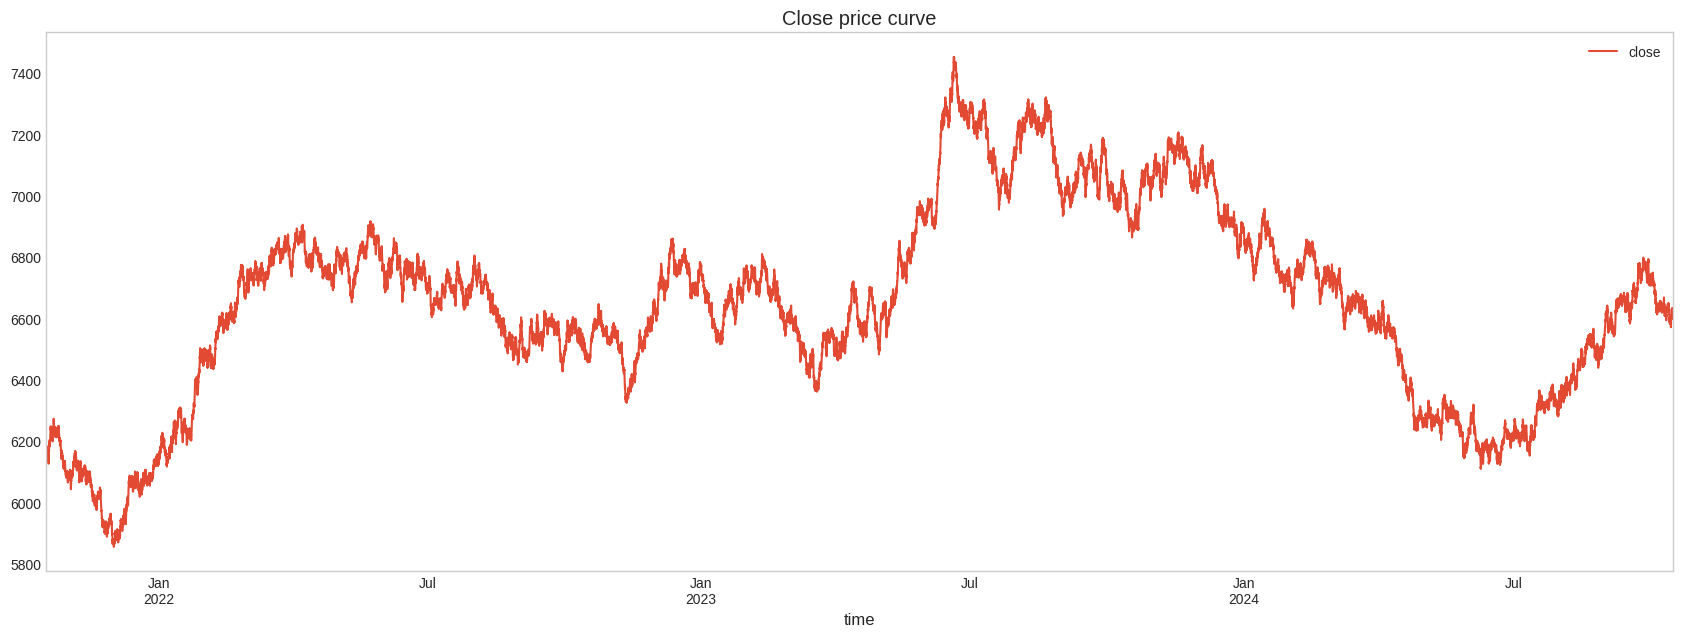

In [50]:
# Display
fig = plt.figure(figsize=(21,7))
dl_data[LABEL_TARGET].plot(label=LABEL_TARGET, title=f"{LABEL_TARGET} Price curve".capitalize())
plt.grid()
plt.legend()
plt.show()

### Apply Nomalization

In [51]:
settings["features_name"] = dl_data.columns

In [52]:
# NORMALIZATION OF THE DATA
norm = Normalizer(data=[{"name": dl_selected_symbols.iloc[0], "data": dl_data}])
norm.fit(settings["normalization_fit_type"], settings["features_name"], settings["normalization_fit_target"])


Performing StandardScale Normalization on all.


In [53]:
normalize_data = norm.get_normalized_data(0)

normalize_data

,open,high,low,close,tick_volume,spread,real_volume,returns,sLow,sHigh,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
0,-1.499242,-1.506966,-1.496564,-1.491833,0.047592,0.305536,0.0,162.107989,-162.107989,162.107989,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
1,-1.490409,-1.495323,-1.485759,-1.491836,0.155027,0.305536,0.0,-0.006169,0.006169,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
2,-1.491753,-1.495085,-1.484456,-1.482800,0.101309,0.305536,0.0,-0.006169,0.006169,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
3,-1.482444,-1.494692,-1.507455,-1.523019,-0.006126,0.305536,0.0,-0.006169,0.006167,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
4,-1.522143,-1.536708,-1.525158,-1.533283,-0.059844,0.305536,0.0,-0.006169,0.006169,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,-0.100466,-0.092794,-0.086054,-0.100110,0.155027,1.413341,0.0,-0.006169,0.006170,-0.006169,...,2.169737,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
26276,-0.100685,-0.117155,-0.117467,-0.134348,0.101309,1.413341,0.0,-0.006169,0.006167,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
26277,-0.133959,-0.122142,-0.120383,-0.114930,0.262462,1.413341,0.0,-0.006168,0.006170,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518
26278,-0.114609,-0.096097,-0.101600,-0.079866,0.047592,1.413341,0.0,-0.006168,0.006170,-0.006169,...,-0.006542,0.078757,-0.013795,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518


### Apply PEAKS DETECTION

In [54]:
peaks_max, peaks_min = peaks_detection(normalize_data[settings["normalization_target"]], settings["label_disparity"])

In [55]:
np.mean(peaks_max.flatten())

6559.896454449588

In [56]:
np.median(peaks_max.flatten())

7.790663125556298

In [57]:
np.mean(peaks_min.flatten())

6552.106941306935

In [58]:
np.median(peaks_min.flatten())

2.38434847525502

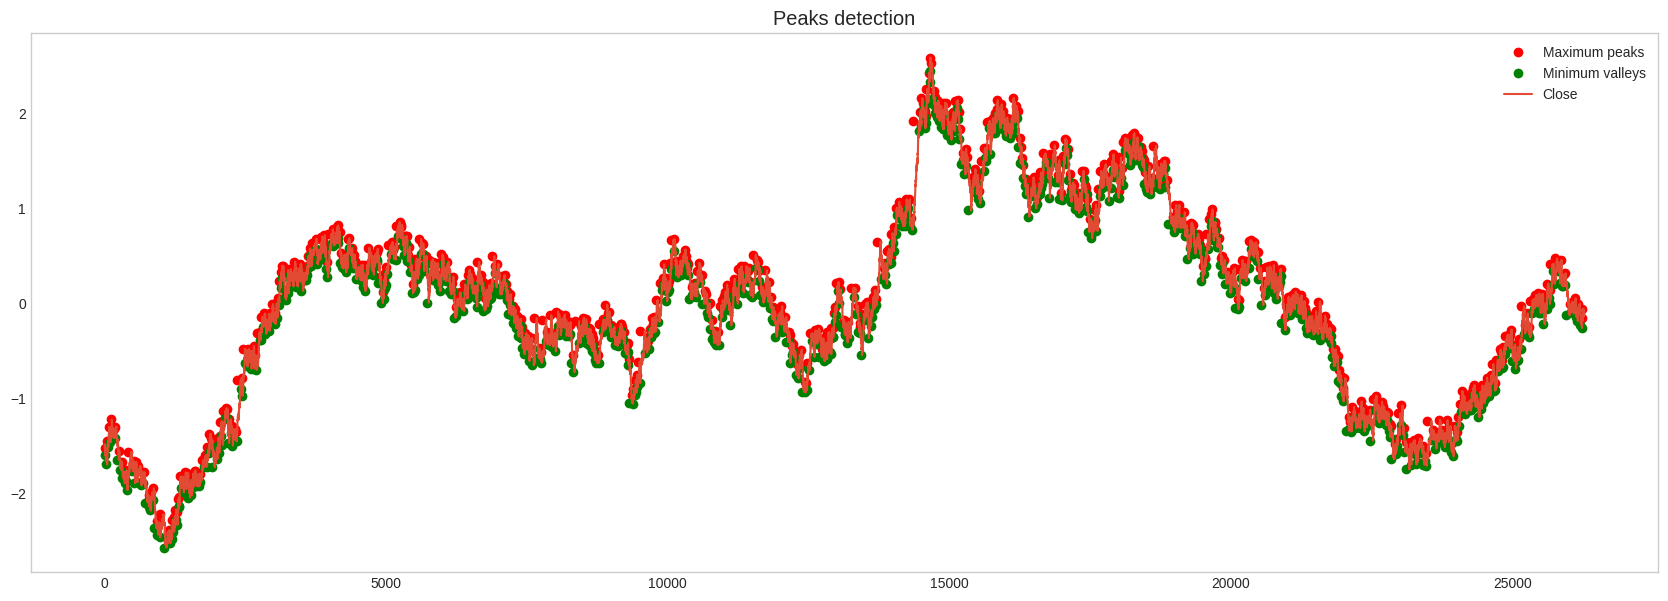

In [59]:
# Display peaks
fig = plt.figure(figsize=(21, 7))
plt.plot(peaks_max[:,0], peaks_max[:, 1], 'ro', label="Maximum peaks")
plt.plot(peaks_min[:,0], peaks_min[:, 1], 'go', label="Minimum valleys")
plt.plot(normalize_data[LABEL_TARGET], label=LABEL_TARGET.capitalize())
plt.grid()
plt.title("Peaks detection")
plt.legend()
plt.show()

### Apply Frame labelization

LABELIZATION WITH PEAKS

In [60]:
%%time

labeler = MarketLabeler(peaks_max, peaks_min)
labeled_normalize_df = labeler.label_dataframe(normalize_data, LABEL_TARGET)

CPU times: user 50 s, sys: 90.7 ms, total: 50.1 s
Wall time: 50.3 s


In [61]:
labeled_normalize_df

,open,high,low,close,tick_volume,spread,real_volume,returns,sLow,sHigh,...,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS,buy,sell,neutral
0,-1.499242,-1.506966,-1.496564,-1.491833,0.047592,0.305536,0.0,162.107989,-162.107989,162.107989,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,1,0,0
1,-1.490409,-1.495323,-1.485759,-1.491836,0.155027,0.305536,0.0,-0.006169,0.006169,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
2,-1.491753,-1.495085,-1.484456,-1.482800,0.101309,0.305536,0.0,-0.006169,0.006169,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
3,-1.482444,-1.494692,-1.507455,-1.523019,-0.006126,0.305536,0.0,-0.006169,0.006167,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
4,-1.522143,-1.536708,-1.525158,-1.533283,-0.059844,0.305536,0.0,-0.006169,0.006169,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,-0.100466,-0.092794,-0.086054,-0.100110,0.155027,1.413341,0.0,-0.006169,0.006170,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
26276,-0.100685,-0.117155,-0.117467,-0.134348,0.101309,1.413341,0.0,-0.006169,0.006167,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
26277,-0.133959,-0.122142,-0.120383,-0.114930,0.262462,1.413341,0.0,-0.006168,0.006170,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1
26278,-0.114609,-0.096097,-0.101600,-0.079866,0.047592,1.413341,0.0,-0.006168,0.006170,-0.006169,...,-0.101695,0.006431,0.047836,0.006169,-0.010685,0.0,0.001518,0,0,1


### Apply Data Generator - Split Normalized Data

horizon (int): The number of forward terms of the target time series to be estimated

In [62]:
data_generator = DataGenerator(labeled_normalize_df, settings["nb_per_bloc"], settings["features_name"], settings["labels_name"])


In [63]:
%%time
x_train, y_train, x_test, y_test = data_generator.train_test_split(settings["split_test"], settings["is_balance"])


CPU times: user 22.5 s, sys: 244 ms, total: 22.8 s
Wall time: 22.7 s


In [64]:
x_train.shape, y_train.shape

((2002, 4, 123), (2002, 3))

In [65]:
x_train.dtype, y_train.dtype


(dtype('float32'), dtype('float32'))

In [66]:
y_train[0]

array([0., 1., 0.], dtype=float32)

### Model Experiments

In [67]:
# from keras.layers import Input, Dense, Dropout, Bidirectional, Reshape
# from keras.callbacks import EarlyStopping
# from keras.metrics import F1Score, FBetaScore, Precision, Recall 
# from tcn import TCN, tcn_full_summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from pytorch_tcn import TCN

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# https://github.com/paul-krug/pytorch-tcn
# https://github.com/locuslab/TCN/

#### Define Model Util functions (for Neural Nets)

In [68]:
def calculate_lstm_neurons(data_array: np.array, settings: dict) -> int:
    """
    Calculates the number of neurons for an LSTM network based on data and settings.

    Args:
        data_array (np.array): The numpy array containing the training data.
        settings (dict): A dictionary containing settings for neuron calculation.
            - features_name (list): Names of features for training.
            - labels_name (list): Names of output labels (classes).
            - delta_neurons_numbers (int): Hyperparameter scaling the number of neurons.

    Returns:
        int: The calculated number of neurons for the LSTM network.

    Raises:
        ValueError: If required keys are missing from the settings dictionary.
    """

    if not all(key in settings for key in ["features_name", "labels_name", "delta_neurons_numbers"]):
        raise ValueError("Missing required keys in 'settings' dictionary.")

    num_features = len(settings["features_name"])
    num_labels = len(settings["labels_name"])
    num_samples = data_array.shape[0]
    scaling_factor = settings["delta_neurons_numbers"]

    return int(num_samples / (scaling_factor * (num_features + num_labels)))


In [69]:
from torch.utils.data import TensorDataset, DataLoader

def create_train_test_set(x_train, x_test, y_train, y_test):
    """Creates train and test datasets from numpy arrays or lists.

    Args:
        x_train: Training features.
        x_test: Test features.
        y_train: Training labels.
        y_test: Test labels.

    Returns:
        training_data: A TensorDataset for the training set.
        test_data: A TensorDataset for the test set.
    """
    # Convert to torch tensors
    tensor_x_train = torch.Tensor(x_train)
    tensor_y_train = torch.Tensor(y_train)
    training_data = TensorDataset(tensor_x_train, tensor_y_train)  # Create training dataset

    tensor_x_test = torch.Tensor(x_test)
    tensor_y_test = torch.Tensor(y_test)
    test_data = TensorDataset(tensor_x_test, tensor_y_test)  # Create test dataset

    return training_data, test_data


In [70]:
# https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm
# x_tcn = GlobalAveragePooling1D()(x_tcn)
 
# SET NUMBER OF NEURONS
settings["model_neural"] = calculate_lstm_neurons(x_train, settings)  
settings["model_neural_hidden"] =  settings["model_neural"] + int(settings["model_neural"] / 2) # int(settings["model_neural"] / 2)

settings["model_neural"], settings["model_neural_hidden"]

(7, 10)

In [71]:
# Model parameters
input_dim = x_train.shape[2]  # Feature size per time step (input dimension)
hidden_dim_1 = settings["model_neural"]  # Hidden layer size
hidden_dim_2 = settings["model_neural_hidden"]  # Hidden layer size
output_dim = y_train.shape[1]  # Number of output classes
device = "cpu"
models = {}
trained_models = {}

In [72]:
training_data, test_data = create_train_test_set(x_train, x_test, y_train, y_test)

train_dataloader = DataLoader(training_data, batch_size=settings["model_evaluate_batch_size"], shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=settings["model_evaluate_batch_size"], shuffle=False)

#### Model A (Bi-LSTM)

In [73]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers: int = 4, **kwargs):
        super(BidirectionalLSTMModel, self).__init__()

        self.hidden_size = hidden_size or 24

        self.num_layers = num_layers

        # Bidirectional LSTMs
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.2)

        # Dropout layer
        # self.dropout = nn.Dropout(0.2)

        # Dense (fully connected) layer with softmax activation
        self.fc = nn.Linear(hidden_size*2, output_size) 

    def forward(self, x):
        # Set initial hidden and cell states 
        # h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)

        # Passing input through LSTMs
        out, _ = self.bilstm(x) # out, hidden = self.bilstm(x, (h0, c0))
        # out = self.dropout(out)

        # Taking the output of the last time step
        out = out[:, -1, :]

        fc = self.fc(out)
        x = F.softmax(fc)
        return x


# Model instantiation
models["BidirectionalLSTM"] = BidirectionalLSTMModel(input_size=input_dim, hidden_size=hidden_dim_1, output_size=output_dim)

# Summary 
print(models["BidirectionalLSTM"])


BidirectionalLSTMModel(
  (bilstm): LSTM(123, 7, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=14, out_features=3, bias=True)
)


#### Model B (Bi-GRU)

In [74]:
class BidirectionalGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers: int = 4, **kwargs):
        super(BidirectionalGRUModel, self).__init__()

        self.hidden_size = hidden_size or 24

        self.num_layers = num_layers

        # Bidirectional GRU layers
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        
        # Dense (fully connected) layer with softmax activation
        self.fc = nn.Linear(hidden_size*2, output_size) 
        
    def forward(self, x):
        # Forward pass through bidirectional GRU layers
        out, _ = self.bigru(x)
        
        # Taking the output of the last time step
        out = out[:, -1, :]

        fc = self.fc(out)
        x = F.softmax(fc)
        return x

models["BidirectionalGRU"] = BidirectionalGRUModel(input_size=input_dim, hidden_size=hidden_dim_1, output_size=output_dim)

# Summary 
print(models["BidirectionalGRU"])

BidirectionalGRUModel(
  (bigru): GRU(123, 7, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=14, out_features=3, bias=True)
)


#### Model C (TCN)

In [75]:
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels: Tuple = (2, 3, 5, 8, 16, 32), kernel_size: int = 5, dilations: Tuple = (1, 2, 4, 8, 16, 32)):
        super(TCNModel, self).__init__()

        # Define the TCN layer with appropriate parameters
        self.tcn = TCN(input_size, num_channels, kernel_size, dilations, input_shape='NLC', dropout=0.2)

        # Fully connected layer with input size matching the last TCN channel size
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # Passing input through the TCN layer
        out = self.tcn(x)

        # Taking the output of the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layer
        fc = self.fc(out)
        
        x = F.softmax(fc)
        return x  


# Model instantiation
models["TCN"] = TCNModel(input_size=input_dim, output_size=output_dim)

# Summary 
print(models["TCN"])


TCNModel(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          123, 2, kernel_size=(5,), stride=(1,)
          (padder): ConstantPad1d(padding=(4, 0), value=0.0)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          2, 2, kernel_size=(5,), stride=(1,)
          (padder): ConstantPad1d(padding=(4, 0), value=0.0)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(123, 2, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (con

In [76]:
models

{'BidirectionalLSTM': BidirectionalLSTMModel(
   (bilstm): LSTM(123, 7, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
   (fc): Linear(in_features=14, out_features=3, bias=True)
 ),
 'BidirectionalGRU': BidirectionalGRUModel(
   (bigru): GRU(123, 7, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
   (fc): Linear(in_features=14, out_features=3, bias=True)
 ),
 'TCN': TCNModel(
   (tcn): TCN(
     (network): ModuleList(
       (0): TemporalBlock(
         (conv1): ParametrizedTemporalConv1d(
           123, 2, kernel_size=(5,), stride=(1,)
           (padder): ConstantPad1d(padding=(4, 0), value=0.0)
           (parametrizations): ModuleDict(
             (weight): ParametrizationList(
               (0): _WeightNorm()
             )
           )
         )
         (conv2): ParametrizedTemporalConv1d(
           2, 2, kernel_size=(5,), stride=(1,)
           (padder): ConstantPad1d(padding=(4, 0), value=0.0)
           (parametrizations): ModuleDict(
 

#### Training


In [77]:
def train_model(model: nn.Module,
                model_optimizer: str,
                model_loss: str,
                num_epochs: int = 20,
                dataloader: Optional[DataLoader] = None,
                device: Optional[str] = None) -> tuple[nn.Module, optim.Optimizer, nn.Module]:
    """Trains a PyTorch model.

    Args:
        model: The PyTorch model to train.
        model_optimizer: The name of the optimizer to use.
        model_loss: The name of the loss function to use.
        num_epochs: The number of epochs to train for.
        dataloader: The DataLoader object for loading data.
        device: The device to use for training (e.g., 'cpu', 'cuda').

    Returns:
        A tuple containing the trained model, optimizer, and loss function.
    """

    if dataloader is None:
        raise ValueError("A DataLoader object must be provided.")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # Optimizer
    optimizer_class = getattr(optim, model_optimizer.capitalize())
    optimizer = optimizer_class(model.parameters())

    # Loss function
    loss_function = getattr(nn, model_loss)()

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    return model, optimizer, loss_function

In [78]:
for name, model in models.items(): 
    print(f"{name} Model:")
    trained_models[name] = train_model(models[name], settings["model_optimizer"], settings["model_loss"], settings['model_epoch'], train_dataloader)


BidirectionalLSTM Model:
Epoch 1/60, Loss: 1.0929
Epoch 2/60, Loss: 0.9806
Epoch 3/60, Loss: 0.8680
Epoch 4/60, Loss: 0.7405
Epoch 5/60, Loss: 0.6916
Epoch 6/60, Loss: 0.6710
Epoch 7/60, Loss: 0.7959
Epoch 8/60, Loss: 0.6252
Epoch 9/60, Loss: 0.6220
Epoch 10/60, Loss: 0.6298
Epoch 11/60, Loss: 0.6636
Epoch 12/60, Loss: 0.6107
Epoch 13/60, Loss: 0.6164
Epoch 14/60, Loss: 0.6209
Epoch 15/60, Loss: 0.6926
Epoch 16/60, Loss: 0.6767
Epoch 17/60, Loss: 0.6156
Epoch 18/60, Loss: 0.6661
Epoch 19/60, Loss: 0.6210
Epoch 20/60, Loss: 0.6433
Epoch 21/60, Loss: 0.6514
Epoch 22/60, Loss: 0.6144
Epoch 23/60, Loss: 0.6647
Epoch 24/60, Loss: 0.6251
Epoch 25/60, Loss: 0.6587
Epoch 26/60, Loss: 0.6642
Epoch 27/60, Loss: 0.6094
Epoch 28/60, Loss: 0.6086
Epoch 29/60, Loss: 0.6092
Epoch 30/60, Loss: 0.6084
Epoch 31/60, Loss: 0.6103
Epoch 32/60, Loss: 0.6090
Epoch 33/60, Loss: 0.6595
Epoch 34/60, Loss: 0.6093
Epoch 35/60, Loss: 0.6311
Epoch 36/60, Loss: 0.6086
Epoch 37/60, Loss: 0.6083
Epoch 38/60, Loss: 0.6

In [79]:
# # Plot real-time
# plotRT = PlotRealTime()

# # Learning stats
# def lr(epoch):
#     if epoch < 15:
#         return 0.0001 # 0.010
#     if epoch < 40:
#         return 0.0095
#     if epoch < 55:
#         return 0.008
#     if epoch < 60:
#         return 0.007
#     if epoch < 150:
#         return 0.0001 # 0.01
    
#     return 0.0001

# def lr2(epoch):
#     if epoch < 100:
#         return 1e-8
    
#     return 1e-4


# # Define early stopping callback
# patience = 25
# early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


# plotter = PlotRealTime()
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[plotter])


# %%time
# hist_a = model_a.fit(x_train,
#                  y_train, 
#                  epochs=settings["model_epoch"],
#                  batch_size=settings["model_batch_size"],
#                  validation_split=settings["model_validation_split"],
#                  verbose=1,
#                  shuffle=settings["model_shuffle"],
#                  callbacks=[plotRT, early_stopping, LearningRateScheduler(lr, verbose=1)])

# model_a.save(f"../models/{file_name}_model_a_{time.time()}.h5")

#### Evaluate

np.argmax(y_test, axis=1) => {0: 'BUY', '1': 'SELL', 2: 'NEUTRAL'}

In [80]:
metrics = {}

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from typing import Tuple, Optional

def evaluate_model(trained_model: Tuple[nn.Module, Optimizer, nn.Module],
                   dataloader: DataLoader,
                   device: Optional[str] = None) -> dict:
    """Evaluates a PyTorch model on a given dataset.

    Args:
        trained_model: A tuple containing the trained PyTorch model, optimizer, and loss function.
        dataloader: The DataLoader object for loading evaluation data.
        device: The device to use for evaluation (e.g., 'cpu', 'cuda').

    Returns:
        A dictionary containing evaluation metrics like accuracy, precision, recall, F1 score, and confusion matrix.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, optimizer, loss_function = trained_model
    model.to(device)
    model.eval()  # Set the model to evaluation mode


    raw_targets = []
    raw_predictions = []
    all_targets = []
    all_predictions = []
    total_loss = 0

    # Loss function for evaluation 
    criterion = loss_function

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            raw_targets.extend(targets.cpu().numpy())
            raw_predictions.extend(outputs.cpu().numpy())

            # Convert outputs to predicted class (taking the argmax for multi-class classification)
            _, predicted = torch.max(outputs, 1)

            # If targets are one-hot encoded, convert them to class indices
            if len(targets.shape) > 1 and targets.shape[1] > 1:
                targets = torch.argmax(targets, dim=1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    # Return the evaluation metrics in a dictionary
    metrics = {
        "loss": total_loss / len(dataloader),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "raw_targets": raw_targets,
        "raw_predictions": raw_predictions,
    }

    # Display the metrics
    print(f"Evaluation Loss: {metrics['loss']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")

    return metrics


In [82]:
for name, model in trained_models.items():
    print(f"{name} Model:")
    metrics[name] = evaluate_model(trained_models[name], test_dataloader)
    

BidirectionalLSTM Model:
Evaluation Loss: 0.7859
Accuracy: 0.7645
Precision: 0.7607
Recall: 0.7645
F1 Score: 0.7563
Confusion Matrix:
[[134   2  26]
 [  0 150  12]
 [ 34  44  99]]
BidirectionalGRU Model:
Evaluation Loss: 0.7538
Accuracy: 0.7944
Precision: 0.7934
Recall: 0.7944
F1 Score: 0.7874
Confusion Matrix:
[[146   1  15]
 [  2 146  14]
 [ 37  34 106]]
TCN Model:
Evaluation Loss: 0.8274
Accuracy: 0.7246
Precision: 0.7216
Recall: 0.7246
F1 Score: 0.7137
Confusion Matrix:
[[136   7  19]
 [  3 140  19]
 [ 39  51  87]]


##### Performance Table

In [83]:
dl_results = pd.DataFrame(metrics).T.drop(columns=['raw_targets', 'raw_predictions'])

dl_results

,loss,accuracy,precision,recall,f1_score,confusion_matrix
BidirectionalLSTM,0.785902,0.764471,0.760677,0.764471,0.756346,"[[134, 2, 26], [0, 150, 12], [34, 44, 99]]"
BidirectionalGRU,0.753796,0.794411,0.793414,0.794411,0.787434,"[[146, 1, 15], [2, 146, 14], [37, 34, 106]]"
TCN,0.827424,0.724551,0.721582,0.724551,0.713733,"[[136, 7, 19], [3, 140, 19], [39, 51, 87]]"


##### Confusion Matrix

In [84]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, label_map: dict = {0: 'BUY', 1: 'SELL', 2: 'NEUTRAL'}):
    """Plots the confusion matrix using a heatmap.

    Args:
        conf_matrix: The confusion matrix to plot (numpy array or similar).
        label_map: A dictionary mapping label indices to actual class names.

    Returns:
        None. Displays the confusion matrix plot.
    """
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()

    # Create heatmap with the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)  # annot=True to annotate cells, fmt='g' for plain numbers

    # Add labels, title, and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_title('Confusion Matrix')

    # Set tick labels based on label_map
    labels = list(label_map.values())
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    # Show the plot
    plt.show()


BidirectionalLSTM Model:


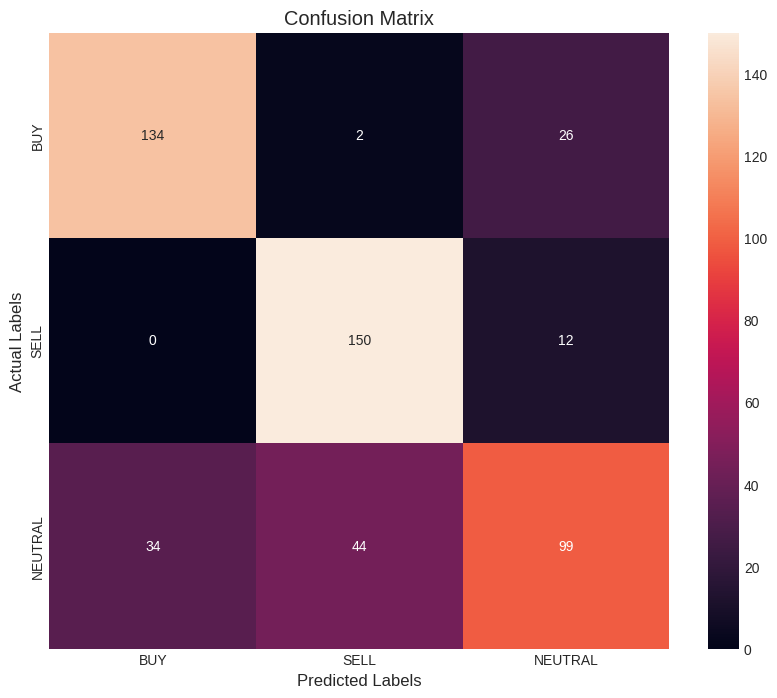

BidirectionalGRU Model:


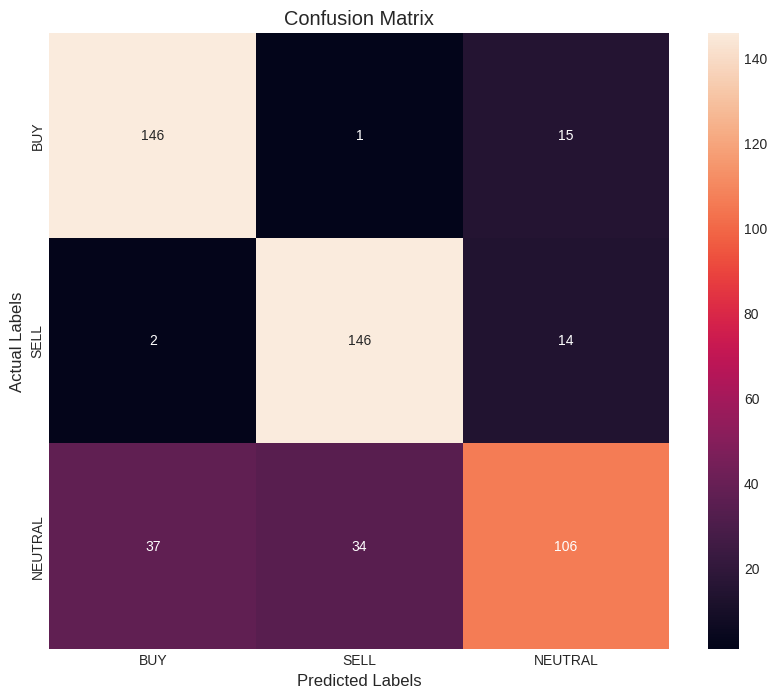

TCN Model:


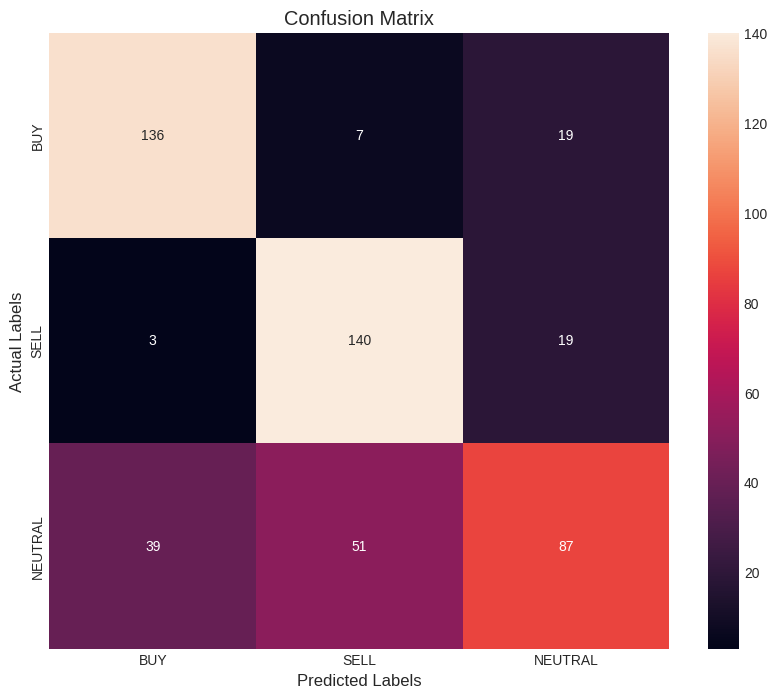

In [85]:
for name, metric in metrics.items():
    print(f"{name} Model:")
    conf_matrix = metric['confusion_matrix']
    plot_confusion_matrix(conf_matrix, label_map={0: 'BUY', 1: 'SELL', 2: 'NEUTRAL'})
    

##### ROC curve

In [86]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_pred, y_test, classes=[0, 1, 2]):
    """
    Plots the ROC curves for multi-class classification.

    Args:
        y_pred (numpy array): Predicted probabilities for each class, shape (n_samples, n_classes).
        y_test (numpy array): True class labels, shape (n_samples,).
        classes (list): List of classes. Default is [0, 1, 2].

    Returns:
        None. Displays the ROC curve plot.
    """
    # Binarize the output for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    # Initialize dictionaries to store False Positive Rates, True Positive Rates, and AUCs for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    # Interpolate all ROC curves and compute the mean True Positive Rate (macro-average)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))

    # Micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='blue', linestyle=':', linewidth=4)

    # Macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    # ROC curves for each class
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    # Plot the diagonal (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Add labels, title, and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


BidirectionalLSTM Model:


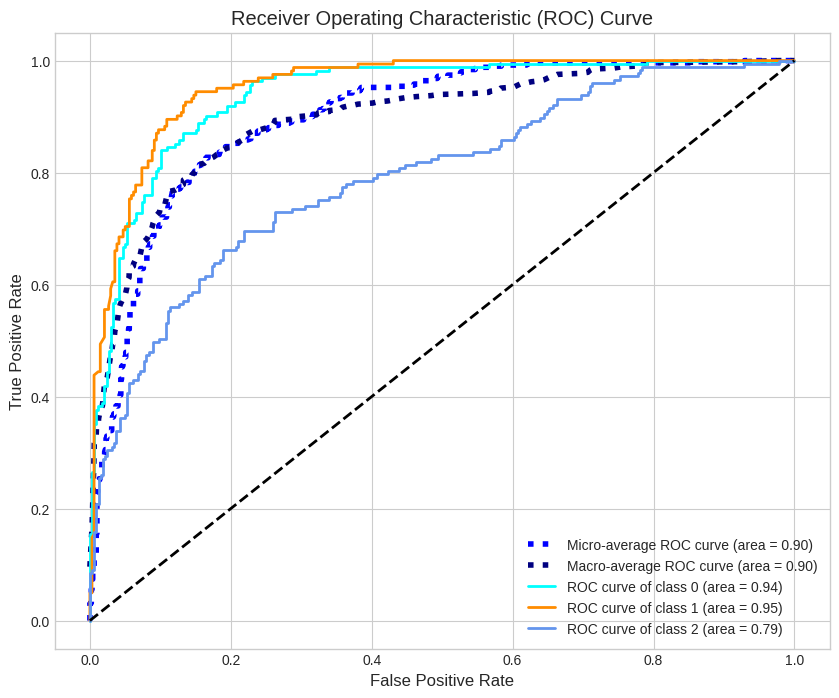

BidirectionalGRU Model:


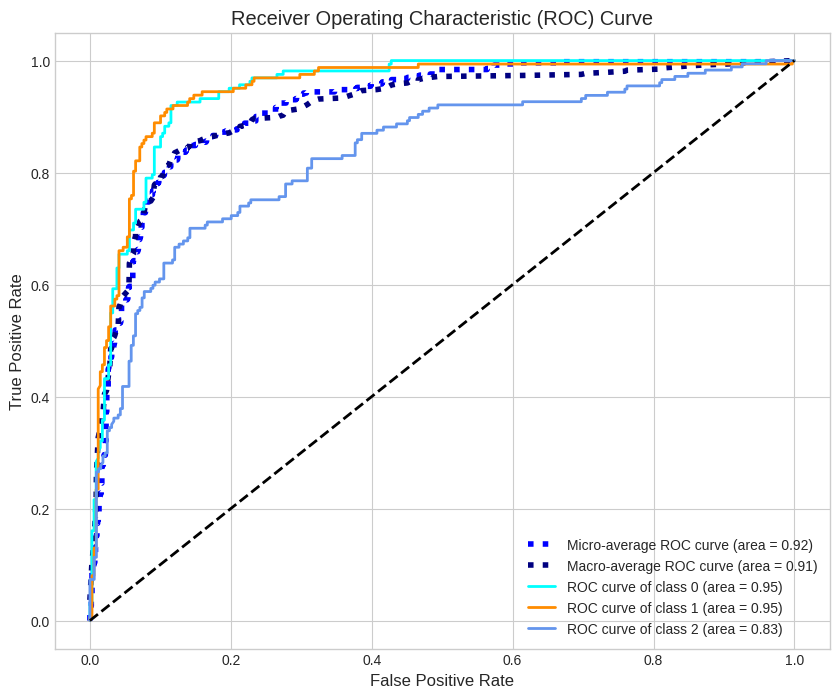

TCN Model:


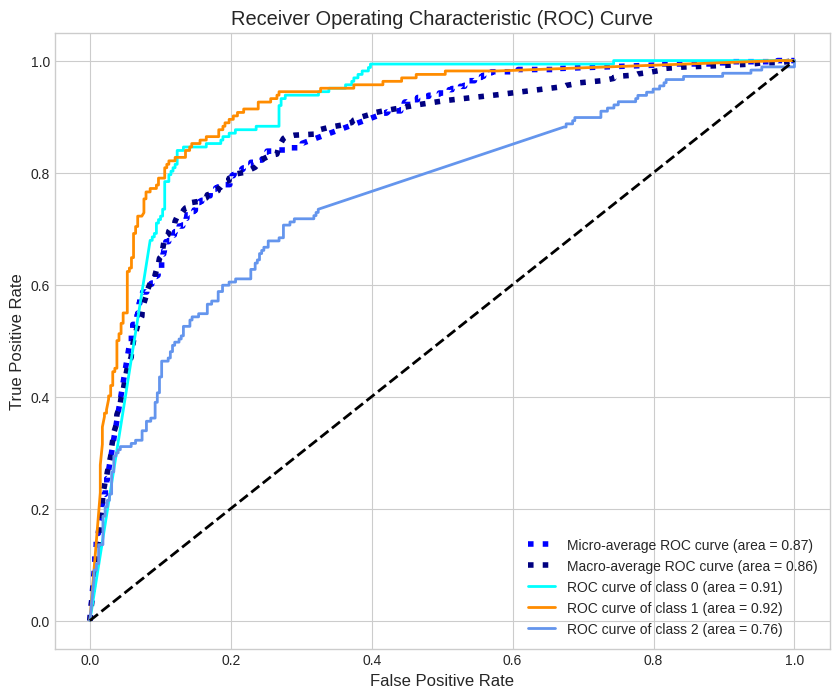

In [87]:
for name, metric in metrics.items():
    print(f"{name} Model:")

    # Convert lists of arrays to 2D NumPy arrays
    raw_predictions = np.array(metric['raw_predictions'])
    raw_targets = np.array(metric['raw_targets'])

    plot_roc_curve(raw_predictions, raw_targets)
    

#### Save Models

In [88]:
from pathlib import Path

model_dir = Path(os.getcwd()).parent / 'models'
# model_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist


def save_model(trained_model: Tuple[nn.Module, optim.Optimizer, nn.Module], path: str) -> None:
    """
    Saves the complete training state of a PyTorch model to a file.

    This function saves the model's state dictionary, containing the learned
    parameters (weights and biases), along with the state dictionaries of the
    optimizer and the loss function. This allows you to load the entire training
    state later and resume training from the saved point or use the model for
    inference.

    Args:
        trained_model: A tuple containing the trained PyTorch model (nn.Module),
                       optimizer (optim.Optimizer), and loss function (nn.Module).
        path: The path to the file where the training state will be saved (str).

    Returns:
        None
    """

    model, optimizer, loss_function = trained_model
    state_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_function': loss_function.state_dict(),  # Save loss function instance (for class-based)
    }
    torch.save(state_dict, path)


def load_model(model_definitions: Tuple[nn.Module, optim.Optimizer, nn.Module], path: str) -> Tuple[nn.Module, optim.Optimizer, nn.Module]:
    """
    Loads a previously saved PyTorch model training state from a file.

    Args:
        path: The path to the file where the training state is saved (str).

    Returns:
        A tuple containing the loaded PyTorch model (nn.Module), optimizer (optim.Optimizer),
        and loss function (nn.Module).
    """
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No model file found at {path}.")

    model, optimizer, loss_function = model_definitions
    state_dict = torch.load(path)
    model = model.load_state_dict(state_dict['model_state_dict'])
    optimizer = optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    loss_function = loss_function.load_state_dict(state_dict['loss_function']) 

    return model, optimizer, loss_function

In [89]:
for name, model in trained_models.items():
    print(f"{name} Model:")
    print(model)
    # Save the model using joblib
    model_filename = os.path.join(model_dir, f"{dl_selected_symbols.iloc[0]}_{name}.pth")
    save_model(model, model_filename)
    print(f"Model saved to {model_filename}")


BidirectionalLSTM Model:
(BidirectionalLSTMModel(
  (bilstm): LSTM(123, 7, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=14, out_features=3, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), CrossEntropyLoss())
Model saved to /home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/packages/tf_trade/models/Volatility 10 Index_BidirectionalLSTM.pth
BidirectionalGRU Model:
(BidirectionalGRUModel(
  (bigru): GRU(123, 7, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=14, out_features=3, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
 

In [90]:
# Load Models
model_definitions = trained_models['BidirectionalLSTM']
model_filename = os.path.join(model_dir, f"{dl_selected_symbols.iloc[0]}_BidirectionalLSTM.pth")

trained_model = load_model(model_definitions, model_filename)
trained_model

(<All keys matched successfully>, None, <All keys matched successfully>)

# DUMP

In [ ]:
# # Import the necessary libraries
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from tqdm import tqdm

# # Initialize models
# tree = DecisionTreeClassifier(max_depth=20)
# svr = SVC(C=1.5)
# lin = LogisticRegression()

# # Initialize MetaTrader 5 or other data source
# mt5.initialize()

# # Symbols list from final_assets
# symbols = final_assets["Symbol"]

# # To store results
# results_list = []

# # Iterate over all symbols
# for symbol in tqdm(symbols):
#     print(symbol, "\n")
#     try:
#         # Retrieve data for the symbol
#         df = get_data(symbol, 3500, mt5.TIMEFRAME_D1).dropna()
        
#         # Perform feature engineering
#         processed_data = features_engineering(df)

#         # Decision Tree
#         sharpe_tree = predictor(processed_data, tree, reg=True)
#         results_list.append([symbol, "Tree", sharpe_tree, len(df)])

#         # # SVM (Support Vector Classifier)
#         sharpe_svr = predictor(processed_data, svr, reg=False)
#         results_list.append([symbol, "SVR", sharpe_svr, len(df)])

#         # Logistic Regression
#         sharpe_linreg = predictor(processed_data, lin, reg=False)
#         results_list.append([symbol, "LinReg", sharpe_linreg, len(df)])

#     except KeyError:
#         continue
    
#     except Exception as e:
#         print(f"Issue during data importation or processing for symbol {symbol}: {e}")
#         raise



In [91]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

# class Normalizer:
#     """
#     A class for normalizing market data while preserving the original data.

#     This class applies logarithm and a normalization (MinMax, StandardScale, Normalizer_l1, Normalizer_l2).
#     """

#     def __init__(self, data):
#         """
#         Initializes the Normalizer class with market data.

#         Args:
#             data (list[dict]): A list of dictionaries, where each dictionary represents a market
#                                with keys like "name" and "data" (containing market data).
#         """
#         self.__market_names = [e["name"] for e in data]
#         self.__original_data = [pd.DataFrame(e["data"]) for e in data]  # Convert to DataFrame
#         self.__normalized_data = None  # Stores normalized data after fit is called

#     def __normalize(self, target, numerical_data, scaler_func):
#         """
#         Normalizes data using the provided scaler function for specific target markets.

#         Args:
#             target (str): The target market(s) to normalize ("all" or a list of market names).
#             numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
#             scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).

#         Returns:
#             list[pd.DataFrame]: List of normalized market DataFrames.
#         """
#         normalized_markets = []
#         target_markets = self.__market_names if target == "all" else target

#         for market_name, market in zip(self.__market_names, numerical_data):
#             if market_name in target_markets:
#                 columns = market.columns
#                 market_scaled = scaler_func(market)
#                 normalized_markets.append(pd.DataFrame(market_scaled, columns=columns))

#         return normalized_markets

#     def fit(self, norm_type, features_list, target="all"):
#         """
#         Performs data normalization based on the specified type, features, and target market(s).

#         Args:
#             norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
#             features_list (list): A list of feature names to consider for normalization.
#             target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

#         Raises:
#             ValueError: If an invalid normalization type is provided.
#         """
#         # Extract numerical data for the specified features
#         numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

#         if norm_type == "MinMax":
#             print(f"Performing MinMax Normalization on {target}.")
#             scaler_func = MinMaxScaler().fit_transform
#         elif norm_type == "StandardScale":
#             print(f"Performing StandardScale Normalization on {target}.")
#             scaler_func = StandardScaler().fit_transform
#         elif norm_type.startswith("Normalizer"):
#             norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
#             if norm_value not in ("l1", "l2"):
#                 raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
#             print(f"Performing Normalizer (norm={norm_value}) on {target}.")
#             scaler_func = SklearnNormalizer(norm=norm_value).fit_transform
#         else:
#             raise ValueError(f"Invalid normalization type: {norm_type}")

#         self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)

#     def get_normalized_data(self, idx: int = None):
#         """
#         Returns the normalized data if normalization has been performed, otherwise raises an error.
        
#         Args:
#             idx (int, optional): The location/index of the normalized data. If None, returns all normalized data.

#         Raises:
#             RuntimeError: If data has not been normalized yet.
#             IndexError: If the index is out of range.
#         """
#         if self.__normalized_data is None:
#             raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
#         if idx is not None:
#             if idx < 0 or idx >= len(self.__normalized_data):
#                 raise IndexError("Index out of range.")
#             return self.__normalized_data[idx]
        
#         return self.__normalized_data  # Return all normalized data if idx is None

#     def get_original_data(self):
#         """
#         Returns the original, un-normalized data.
#         """
#         return [data.copy() for data in self.__original_data]  # Return a deep copy


In [92]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

# class Normalizer:
#     """
#         A class for normalizing market data while preserving the original data.
#     """

#     def __init__(self, data):
#         """
#             Initializes the Normalizer class with market data.

#             Args:
#                 data (list[dict]): A list of dictionaries, where each dictionary represents a market
#                                    with keys like "name" and "data" (containing market data).
#         """
#         self.__market_names = [e["name"] for e in data]
#         self.__original_data = [e["data"] for e in data]  # TODO: Deep copy to preserve original data
#         self.__normalized_data = None  # Stores normalized data after fit is called

#     def __normalize(self, target, numerical_data, scaler_func):
#         """
#             Normalizes data using the provided scaler function for specific target markets.

#             Args:
#                 target (str): The target market(s) to normalize ("all" or a list of market names).
#                 numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
#                 scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).
#         """
#         normalized_markets = []
#         if target == "all":
#             for market in numerical_data:
#                 columns = market.columns
#                 market_scaled = scaler_func(market)
#                 market_scaled = pd.DataFrame(market_scaled, columns=columns)
#                 normalized_markets.append(market_scaled)
#         else:
#             for market_name, market in zip(self.__market_names, numerical_data):
#                 if market_name in target:
#                     columns = market.columns
#                     market_scaled = scaler_func(market)
#                     market_scaled = pd.DataFrame(market_scaled, columns=columns)
#                     normalized_markets.append(market_scaled)
                    
#         return normalized_markets

#     def fit(self, norm_type, features_list, target="all"):
#         """
#             Performs data normalization based on the specified type, features, and target market(s).

#             Args:
#                 norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
#                 features_list (list): A list of feature names to consider for normalization.
#                 target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

#             Raises:
#                 ValueError: If an invalid normalization type is provided.
#         """
#         # Extract numerical data for the specified features
#         numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

#         if norm_type == "MinMax":
#             print(f"Performing MinMax Normalization on {target}.")
#             scaler_func = MinMaxScaler().fit_transform
#             self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)
#         elif norm_type == "StandardScale":
#             print(f"Performing StandardScale Normalization on {target}.")
#             scaler_func = StandardScaler().fit_transform
#             self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)
#         elif norm_type.startswith("Normalizer"):
#             norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
#             if norm_value not in ("l1", "l2"):
#                 raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
#             print(f"Performing Normalizer (norm={norm_value}) on {target}.")
#             scaler_func = Normalizer(norm=norm_value).fit_transform
#             self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)
#         else:
#             raise ValueError(f"Invalid normalization type: {norm_type}")

#     def get_normalized_data(self, idx: int = 0):
#         """
#             Returns the normalized data if normalization has been performed, otherwise raises an error.
            
#             Args:
#                 idx (int): The location/index of the normalized data.

#             Raises:
#                 RuntimeError: If data has not been normalized yet.
#                 IndexError: If the index is out of range.
#         """
#         if self.__normalized_data is None:
#             raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
#         if idx < 0 or idx >= len(self.__normalized_data):
#             raise IndexError("Index out of range.")
        
#         if idx is None:
#             return self.__normalized_data
        
#         return self.__normalized_data[idx]

#     def get_original_data(self):
#         """
#             Returns the original, un-normalized data.
#         """
#         return self.__original_data.copy


In [93]:
# def train_model(model, model_optimizer: str, model_loss: str, num_epochs: int = 20, dataloader: Optional[DataLoader] = None):
#     """ 
#     Train Model
#     """
#     # Optimizer
#     optimizer_class = getattr(optim, model_optimizer.capitalize())
#     optimizer = optimizer_class(model.parameters())

#     # Loss function
#     loss_function = getattr(nn, model_loss)()   # Use CrossEntropyLoss for multi-class classification

#     for epoch in range(num_epochs):
#         for inputs, targets in dataloader:  # use DataLoader for batch loading
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = loss_function(outputs, targets)
#             loss.backward()
#             optimizer.step()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

#     return model, optimizer, loss_function

In [94]:
# def create_train_test_set(x_train, x_test, y_train, y_test):
#     """Creates train and test datasets from numpy arrays or lists.

#     Args:
#         x_train: Training features.
#         x_test: Test features.
#         y_train: One-hot encoded training labels.
#         y_test: One-hot encoded test labels.

#     Returns:
#         training_data: A TensorDataset for the training set.
#         test_data: A TensorDataset for the test set.
#     """
#     # Convert to torch tensors
#     tensor_x_train = torch.Tensor(x_train)
#     tensor_y_train = torch.argmax(torch.Tensor(y_train), dim=1).long()  # Convert one-hot to class indices
#     training_data = TensorDataset(tensor_x_train, tensor_y_train)  # Create training dataset

#     tensor_x_test = torch.Tensor(x_test)
#     tensor_y_test = torch.argmax(torch.Tensor(y_test), dim=1).long()  # Convert one-hot to class indices
#     test_data = TensorDataset(tensor_x_test, tensor_y_test)  # Create test dataset

#     return training_data, test_data


In [95]:

# def predictor(data: dict, model, reg: bool = True, spread: float = 0.035, compressed_features: bool = True) -> float:
#     """
#     Fits the model to the training data, makes predictions on the entire dataset, 
#     and computes the strategy's Sharpe ratio based on the predictions.
    
#     Args:
#         data (dict): The output of the features_engineering function, containing the PCA-transformed datasets.
#         model (object): The machine learning model to be used for prediction (e.g., classifier or regressor).
#         reg (bool): If True, performs regression; otherwise, classification.
#         spread (float): The transaction cost or spread to be considered in strategy returns.
#         compressed_features (bool): If True, use PCA-transformed features; otherwise, use original features.

#     Returns:
#         float: The Sharpe ratio of the strategy based on predictions.
#     """

#     # Extract the data from the dictionary
#     X_train = data["X_train_pca"] if compressed_features else data["X_train_scaled"]
#     X_test = data["X_test_pca"] if compressed_features else data["X_test_scaled"]
#     X_val = data["X_val_pca"] if compressed_features else data["X_val_scaled"]
#     y_train_reg = data["y_train_reg"]
#     y_train_cla = data["y_train_cla"]
#     df = data["processed_df"]
#     split_train_test = data["split_train_test"]
#     split_test_valid = data["split_test_valid"]

#     # Fit the model on the training data
#     print("Model type:", type(model).__name__)

#     # Fit the model based on whether it is regression or classification
#     if hasattr(model, 'fit'):
#         # For sklearn models
#         if 'sklearn' in str(type(model)):
#             if reg:
#                 model.fit(X_train, y_train_reg)
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))
#             else:
#                 model.fit(X_train, y_train_cla)
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

#         # For deep learning models (Pytorch, Keras, TensorFlow, etc.)
#         elif hasattr(model, 'predict'):
#             if reg:
#                 model.fit(X_train, y_train_reg, epochs=100, verbose=0)  # Specify epochs as needed
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0)).flatten()
#             else:
#                 model.fit(X_train, y_train_cla, epochs=100, verbose=0)  # Specify epochs as needed
#                 predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

#         else:
#             raise ValueError("Model does not have a 'fit' or 'predict' method.")
#     else:
#         raise ValueError("The provided model does not support fitting.")

#     # Clean the dataframe
#     # df = df.dropna()
#     # Impute missing values using IterativeImputer (Multiple Imputation by Chained Equations)
#     imputer = IterativeImputer(random_state=0)
#     clean_data = imputer.fit_transform(df)
#     df = pd.DataFrame(clean_data, columns=data["processed_df"].columns)


#     # Convert classification predictions to -1 (sell) and 1 (buy)
#     if not reg:
#         predictions = np.where(predictions == 0, -1, 1)
#         # predictions = np.argmax(predictions, axis=1)  # Assuming model returns probabilities

#     # Add predictions to the dataframe
#     df["prediction"] = predictions

#     # Compute the strategy returns (prediction * actual returns)
#     df["strategy"] = df["prediction"] * df["returns"]

#     # Select strategy returns only for the test set period
#     returns = df["strategy"].iloc[split_train_test:split_test_valid]

#     # Compute the Sharpe ratio of the strategy
#     sharpe_ratio = np.sqrt(252) * (returns.mean() - (spread / 100)) / returns.std()

#     return sharpe_ratio
